As an exploration of Machine Learning I chose to run some analyses on the model SegmentNT. This personal exploration is a downstream study of lab research, serving as a way to delve deeper into machine learning models as applied to clinical datasets. This side project allowed me to additionally familiarize myself with huggingface models and the huggingface platform.

My testing framework: 

    a) prepare a data set for machine learning (cleaning, selection, manipulation)
    b) run the model on a given data set
    c) compare output across runs (and across data sets)

# STEPS TO RUN

Run each block of code in the, "RUNNING THE MODEL" section. The functions will read in test data of a reasonable size, and output results in a dedicated folder.

There is no code to run in the "PREPROCESSING SECTION". Likewise, the preprocessing steps are not executable in python. Instead, preprocessing steps are documented as markdown

The test datasets are meant to be read from the same directory as the as the Final Project notebook. Results will be output into the same directory as well

# ABSTRACT
Nucleotide transformers have shown significant potential in functional genomic region prediction. SegmentNT (GitHub repository: https://github.com/instadeepai/nucleotide-transformer), a specialized model, predicts 14 classes of genetic elements, including protein-coding genes and splice sites. This study focuses on exon predictions across 3 samples to evaluate SegmentNT's numerical consistency across overlapping windows and its sensitivity to genomic context using 3 whole-genome sequences from a cohort of 808 ADNI participants, focusing on chromosome 21. Findings reveal high-confidence predictions with localized deviations influenced by genomic context. Future work will explore single-nucleotide prediction stability to enhance the model's generalizability.


# DATA PREPARATION (a)
*The scripts utilized during data preparationare not executable in python notebooks. Additionally, the original datasets are too large to upload to canvas. Therefore, I have included samples of the datasets for running the model, and provided an outline of the steps taken to produce sample data like the ones provided*



##### Table of Contents 
* Data Preprocessing
   - Dataset Selection (selection)
   - Sequence Construction (manipulation)
   - Obtaining Phased Genome Information (manipulation)
   - Input Preparation (cleaning)
       - Capturing Context
       - Retrieving Sequences
* Full Scripts
   - getContext.py
   - getSequences.py

### Data Preprocessing


#### Dataset Selection (selection)


I utilized whole genome sequences from 3 individuals in the Alzheimer’s Disease Neuroimaging Initiative (ADNI). All chromosomes were queried from a .gz file containing the genomic information and sequences for 808 individuals that were diagnosed with Alzheimer’s, Demetia, and Mild Cognitive Impairment. The chromosome data is stored in .vcf files which function similarly to databases. Each .vcf file contains samples with corresponding genomic variant information including genotype, position, reference allele, alternate allele, and chromosome. Each .vcf file corresponds to a particular chromosome for the 808 individuals that were studied, and I chose to focus on 3 samples from chromosome 21, as it is responsible for most gene variants related to neurodegenerative disorders. 

Command:

1. bcftools query -l ADNI.808_indiv.minGQ_21.pass.ADNI_ID.chr21.vcf.gz  | while read S


#### Sequence Construction (manipulation)


To completely reconstruct a sample sequence, I utilized a tool called “FastaReferenceMaker” that enabled me to compare the nucleotide variants and a reference genome. Each nucleotide variant was used in place of the corresponding nucleotides in the reference genome, and an entirely new sequence was created for each sample. This allowed me to maintain the variant nucleotides while including the surrounding genomic context. The reference genome (human_g1k_v37.fasta) was used as a template to create the new FASTA file. Variants from the VCF replaced corresponding bases in the genome file to reflect individual-specific changes. Files were named using the sample identifier and the specified chromosome. For example, sample 941_S_4292 and chromosome chr21, the output file would be named 941_S_4292 __chr21.fasta. Ambiguous base pairs (e.g., heterozygous sites where there are two possible variant in one location) are represented using IUPAC nucleotide codes (e.g., R for A/G, Y for C/T). This substitution became unnecessary since I ensured that two variants will not be represented by a single sequence and represented them using phased sequences. An interval file was used to specify the range of genomic positions for the given chromosome. E.x. If chr21.intervals contains positions from 40,000 to 50,000, the tool will only process nucleotides in this range. When creating a sequence, the intervals included a large range of nucleotides making it necessary to narrow down the sequence using specific intervals. I utilized even more specialized intervals when focusing on specific variant regions. 

Full Script:

1. gatk FastaAlternateReferenceMaker -R /human_g1k_v37.fasta -O "output_apoe/${S}__${chrom}.fasta" --use-iupac-sample "${S}" -L interva    ls/${chrom}.intervals -V ADNI.808_indiv.minGQ_21.pass.ADNI_ID.chr21.vcf.gz


#### Obtaining Phased Genome Information (manipulation)


Using the alternate reference maker allowed me to make a sequence that incorporates ADNI variants, but there are occasions when two variants are inherited on each side of a chromosome. Two variants cannot easily be represented on a single sequence; therefore, the alternate reference maker must replace these variants with an arbitrary character representing both variants (heterozygous). The removal of both variants cuts out a large portion of the genomic context and resulted in the need for me to produce a sequence for each side of the chromosome. 
To remedy this issue, I utilized phased gene sequences as input for the transformer. Phased gene information includes both sides of a chromosome on which a variant occurs. The phasing information was extracted using a tool called Beagle. Beagle utilizes genomic information (the position oFf the variant, the variant versions, and the who each version is inherited from) to create a structure for two separate sequences including each variant. A reference file (plink_map) is used to make this construction more biologically accurate by determining how likely variants will be inherited together employing probabilistic models and population-level patterns. After obtaining the phasing information, the sequence reconstruction process was implemented again, producing phased sequences that maintained variants for each side of the chromosome (haplotypes).

Full Script:

1. time java -Xmx120g -jar beagle.06Aug24.a91.jar map=resources/plink_map/plink.chr${n    um}.GRCh37.map gt=../gatk/ADNI.808_indiv.minGQ_21.pass.ADNI_ID.chr${num}.vcf.gz out    =adni_phased_chr${num}32 num=21


#### Input Preparation (cleaning)

##### Capturing Context


To focus on relevant regions of each DNA sequence, I utilized 1000 nucleotide intervals surrounding AD-associated SNPs (Alzheimer’s Disease associated genomic regioms) reported by Bellenguez et al. Because segmentNT is a large language model, I wanted to ensure that each sequence maintained a significant amount of context on each side of the AD-associated variants. Therefore, I created a script that allowed me to dynamically change the region’s buffer size starting with a buffer of 25000 base pairs on each side of the variant regions. This adjustment ultimately provided me with the opportunity to have a better understanding of the functions of nucleotide subsequences, as well as the influence of genes on their localized area. This context addition is particularly important for variant annotations, as segmentNT aims to serve as a functional region annotation tool. The output of the adjusted regions script supplied me with definitive start and stop points that the following script could use to actively extract sequences from .fasta files.
The script first processed genomic variant data by extending the start and end positions of each variant by a buffer of 25 kilobases (kb). 

    2. def adjust_variant_range(input_file, output_file, buffer=25000):

The input file 'bellenguez_grs_hg19.tsv' contained variant information, with columns representing the chromosome, start position, and end position. The output file followed the same format with adjusted ranges 'adjusted_variant_ranges.txt'.  

    3.     with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    4.         # Write header for the output file (if needed)
    5.         outfile.write("Chromosome\tStart_Position\tEnd_Position\n")

The input file was read by line, skipping the headers. It extracted the chromosome identifier, start position, and stop position. 

    7.         # Process each line in the input file
    8.         for line in infile:
    9.             # Skip header 
    10.             if line.startswith("#") or line.strip() == "":
    11.                 continue
    12.  
    13.             # Split the line into columns
    14.             columns = line.strip().split("\t")
    15.             
    16.             # Extract the necessary values
    17.             chromosome = columns[1]
    18.             start_position = int(columns[2])
    19.             end_position = int(columns[3])        

The buffer was subtracted from the start position and added to the end position to extend the range of each variant. To ensure validity, any negative start positions were adjusted to zero (although this should not have been a problem as bellenguez intervals did not include a starting point of zero).

    21.             # Calculate new start and end positions by adding 25kb
    22.             new_start = max(0, start_position - buffer)  # Ensure no negative positions
    23.             new_end = end_position + buffer

The data was written to the output file in a tab-separated format along with a header specifying the columns (Chromosome, Start_Position, and End_Position)

25.             # Write the updated chromosome and range to the output file
26.             outfile.write(f"{chromosome}\t{new_start}\t{new_end}\n")


##### Retrieving Sequences


The final step of the data preparation process included retrieval of the input sequences. Using the modified genomic regions, I read each side of the samples’ chromosomes into the script. Subsequences were then extracted from the compressed FASTA files based on the modified genomic intervals. For each interval, a corresponding sequence was fetched using the pysam library. The sequences were saved in FASTA format, with headers that corresponded to their genomic coordinates, chromosome sides (haplotypes), and sample ID. Each processed sample was saved in an output directory for use by the nucleotide transformer model. The resulting fasta files included multiple gene sequences for each individual in the ADNI dataset. I chose to focus on an arbitrary sample and tested varying hyperparameters on each sequence from both sides of the chromosome.
A function entitled read_intervals read the modified intervals file containing genomic regions specified by chromosome, start position, and end position. The file was expected to be tab-separated with three columns. The function skipped the header and stored the intervals in a list as tuples, ensuring that each line contained exactly three values.

     4. def read_intervals(intervals_file):
     5.     intervals = []
     6.     with open(intervals_file, 'r') as f:
     7.         for line in f:
     8.             parts = line.strip().split()
                    # Skips the header line
     9.             if len(parts) == 3 and parts[0] != 'Chromosome':  
    10.                 chrom, start, end = parts[0], int(parts[1]), int(parts[2])
    11.                 intervals.append((chrom, start, end))
    12.     return intervals

A function called fetch_sequences_from_fasta retrieved DNA sequences corresponding to the genomic intervals from compressed FASTA file (.fa.bgz). Using the pysam library, it read the sequences from the FASTA file, accommodating intervals specified in the intervals list. For each interval, the function created an output file named after the FASTA file's ID (derived from the filename). Each sequence was written in FASTA format, including a header indicating the genomic coordinates (>chrom:start-end) followed by the sequence. If a sequence could not be fetched (e.g., due to missing regions or mismatched chromosome names), an error message was displayed.

    14. def fetch_sequences_from_fasta(fasta_file, intervals, output_dir):
    15.     ref = pysam.FastaFile(fasta_file)
    16.     fasta_id = os.path.basename(fasta_file).split('.')[0]  
    17.     
    18.     for chrom, start, end in intervals:
    19.         try:
    20.             # Fetch sequence. Removes 'chr' if not present in the FASTA headers
    21.             seq = ref.fetch(chrom.replace('chr', ''), start, end)  
    22.             
    23.             # Create output file path
    24.             output_file = os.path.join(output_dir, f"{fasta_id}.txt")
    25.             
    26.             # Write sequence to output file
    27.             with open(output_file, 'w') as out_f:
    28.                 out_f.write(f">{chrom}:{start}-{end}\n{seq}\n")
    29.             
    30.             print(f"Saved: {output_file}")
    31.         except ValueError as e:
    32.             print(f"Error fetching {chrom}:{start}-{end} from {fasta_file}: {e}")

A third function was designed to coordinate the script’s workflow. It read the intervals from the intervals file and iterated through all .fa.bgz FASTA files in the phased sequences directory. The fetch_sequences_from_fasta function was called for each fasta file to process the sequences and save them to the output directory. If the output directory did not exist, it was created.

    34. def process_fasta_files(fasta_dir, intervals_file, output_dir):
    35.     # Create output directory if it doesn't exist
    36.     if not os.path.exists(output_dir):
    37.         os.makedirs(output_dir)
    38.     
    39.     intervals = read_intervals(intervals_file)
    40.     # Check for compressed FASTA files
    41.     for fasta_file in os.listdir(fasta_dir):
    42.         if fasta_file.endswith('.fa.bgz'):  
    43.             fasta_path = os.path.join(fasta_dir, fasta_file)
    44.             fetch_sequences_from_fasta(fasta_path, intervals, output_dir)
    

### Full Scripts

##### getContext.py

     2. # Function to add 25kb to the lower and upper bounds of each variant location
     3. def adjust_variant_range(input_file, output_file, buffer=25000):
     4.     with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
     5.         # Write header for the output file (if needed)
     6.         outfile.write("Chromosome\tStart_Position\tEnd_Position\n")
     7.         
     8.         # Process each line in the input file
     9.         for line in infile:
    10.             # Skip header 
    11.             if line.startswith("#") or line.strip() == "":
    12.                 continue
    13.  
    14.             # Split the line into columns
    15.             columns = line.strip().split("\t")
    16.             
    17.             # Extract the necessary values
    18.             chromosome = columns[1]
    19.             start_position = int(columns[2])
    20.             end_position = int(columns[3])
    21.             
    22.             # Calculate new start and end positions by adding 25kb Ensure no negative positions
    23.             new_start = max(0, start_position - buffer)  
    24.             new_end = end_position + buffer
    25.  
    26.             # Write the updated chromosome and range to the output file
    27.             outfile.write(f"{chromosome}\t{new_start}\t{new_end}\n")
    28.  
    29. input_file = 'bellenguez_grs_hg19.tsv' 
    30. output_file = 'adjusted_variant_ranges.txt'
    31.  
    32. # Call the function to process the file
    33. adjust_variant_range(input_file, output_file)
    34.  
    35. print(f"Adjusted ranges saved to {output_file}")


##### getSequences.py 



     1. import os
     2. import pysam
     3.  
     4. def read_intervals(intervals_file):
     5.     intervals = []
     6.     with open(intervals_file, 'r') as f:
     7.         for line in f:
     8.             parts = line.strip().split()
                    # Skip header line
     9.             if len(parts) == 3 and parts[0] != 'Chromosome':  
    10.                 chrom, start, end = parts[0], int(parts[1]), int(parts[2])
    11.                 intervals.append((chrom, start, end))
    12.     return intervals
    13.  
    14. def fetch_sequences_from_fasta(fasta_file, intervals, output_dir):
    15.     ref = pysam.FastaFile(fasta_file)
            # Extract the ID from the FASTA file name (before .fa.bgz)
    16.     fasta_id = os.path.basename(fasta_file).split('.')[0]  
    17.     
    18.     for chrom, start, end in intervals:
    19.         try:
    20.             # Fetch sequence removes 'chr' if not present in the FASTA headers
    21.             seq = ref.fetch(chrom.replace('chr', ''), start, end)  
    22.             
    23.             # Create output file path
    24.             output_file = os.path.join(output_dir, f"{fasta_id}.txt")
    25.             
    26.             # Write sequence to output file
    27.             with open(output_file, 'w') as out_f:
    28.                 out_f.write(f">{chrom}:{start}-{end}\n{seq}\n")
    29.             
    30.             print(f"Saved: {output_file}")
    31.         except ValueError as e:
    32.             print(f"Error fetching {chrom}:{start}-{end} from {fasta_file}: {e}")
    33.  
    34. def process_fasta_files(fasta_dir, intervals_file, output_dir):
    35.     # Create output directory if it doesn't exist
    36.     if not os.path.exists(output_dir):
    37.         os.makedirs(output_dir)
    38.     
    39.     intervals = read_intervals(intervals_file)
    40.     
    41.     for fasta_file in os.listdir(fasta_dir):
                # Check for compressed FASTA files
    42.         if fasta_file.endswith('.fa.bgz'):  
    43.             fasta_path = os.path.join(fasta_dir, fasta_file)
    44.             fetch_sequences_from_fasta(fasta_path, intervals, output_dir)
    45.  
    47. fasta_dir = "/mnt/adni/adni_phased/"  
    48. intervals_file = "adjusted_variant_ranges.txt"  
    49. output_dir = "sequences"
    50. process_fasta_files(fasta_dir, intervals_file, output_dir)

# RUNNING THE MODEL (b)
To run the model, I created a script designed to facilitate proper handling of gene sequences for tokenization. Additionally, my goal was to determine how accurately the model predicts functional regions in the gene sequence. To achieve this effect, I implemented a sliding widow that captured overlapping segments of a sequence. The step size could be adjusted for these windows, as well as each window size. I collected all windows and passed each subsequence into the model to produce nucleotide predictions. These predictions were later evaluated across the overlapping sections of each window. In summary, the workflow involved reading and cleaning gene sequences, dividing them into windows, and using a sliding window to generate predictions. The outputs include the probabilities of each nucleotide in the sequence belonging to specific functional features.


### Set Up Virtual Environment 

In [1]:
import os
import sys
import subprocess

# Create a virtual environment and define the name of the virtual environment
venv_name = "myenv"  
# Use Python's built-in venv module to create the virtual environment
subprocess.check_call([sys.executable, "-m", "venv", venv_name]) 

# Define the path to the activation script for the virtual environment
# Different paths are used depending on the operating system
if os.name == "nt":  # For Windows
    activate_script = os.path.join(venv_name, "Scripts", "activate.bat")
else:  # For macOS/Linux
    activate_script = os.path.join(venv_name, "bin", "activate")

# These sequence of shell commands will activate the virtual environment,upgrade pip, 
# install required Python packages, and the virtual environment as a Jupyter kernel 
commands = f"""
{activate_script} && \
pip install --upgrade pip && \
pip install numpy pandas jax[jaxlib] dm-haiku nucleotide-transformer scipy ipykernel && \
python -m ipykernel install --user --name={venv_name} --display-name "Python ({venv_name})"
"""

# The commands are run in a subprocess
# "/bin/bash" is used as the shell for macOS/Linux and the default uses shell on Windows
# If the return code is non-zero, it indicates an error
process = subprocess.run(commands, shell=True, executable="/bin/bash" if os.name != "nt" else None)
if process.returncode != 0:
    raise RuntimeError("Failed to set up the virtual environment and install dependencies.")



### Import Model and Dependencies


In [2]:
import os
import re
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import pandas as pd
import csv

# Import segmemt NT
from nucleotide_transformer.pretrained import get_pretrained_segment_nt_model

# Check for number of available GPU devices
gpu_devices = [device for device in jax.devices() if device.device_kind == "Gpu"]

# If the devices do not exist, the device will default to cpu
if gpu_devices:
    print(f"Using GPU(s): {gpu_devices}")
else:
    os.environ["JAX_PLATFORM_NAME"] = "cpu"
    print("No GPU found. Defaulting to CPU.")
    devices = jax.devices()


# Device and model setup
devices = jax.devices()
print(f"Devices found: {devices}")


No GPU found. Defaulting to CPU.
Devices found: [CpuDevice(id=0)]


### Initialization
The script began by importing necessary libraries, setting up the model and output directory, and ensuring that hyperparameters (max_num_nucleotides and max_num_tokens) were valid. The is_power_of_two function verifies that the max_num_nucleotides parameter is a power of two, a requirement for the model. The model was initialized using the get_pretrained_segment_nt_model function, which loaded a pretrained version 

In [3]:
# Set up output directory
output_dir = "probabilities_output"
os.makedirs(output_dir, exist_ok=True)

# Define Nucleotide Transformer settings. I utilized the values, max_tokenizer_length = 49152
# and max_num_nucleotides = 8192 when I had access to 4 GPUs. However, since this notebook is running on a single 
# CPU, I utilized a different power of 2 as the max_num_nucleotides. 2046 is a multiple of 6 for optimal tokenization
# However, the value itself was largely arbitrarily chosen
max_tokenizer_length = 2046
max_num_nucleotides = 2048 

# This check ensures that max_num_nucleotides is a power of 2. It is not necessary but help debug when I was 
# was testing for optimal hyperparameters.
def is_power_of_two(n):
    return (n & (n - 1) == 0) and n != 0

assert is_power_of_two(max_num_nucleotides), "max_num_nucleotides must be a power of 2."

# Set max_positions to max_num_nucleotides + 1 as stated in the documentation
max_positions = max_num_nucleotides + 1

# Load the pretrained model with updated max_positions
parameters, forward_fn, tokenizer, config = get_pretrained_segment_nt_model(
    model_name="segment_nt",
    embeddings_layers_to_save=(29,),
    attention_maps_to_save=((1, 4), (7, 10)),
    max_positions=max_positions,
)

forward_fn = hk.transform(forward_fn)
apply_fn = jax.pmap(forward_fn.apply, devices=devices, donate_argnums=(0,))


Downloaded model's hyperparameters.
Downloaded model's weights...


### Ensure Valid Characters & Extract Genomic Position
The clean_sequence function processed sequences by removing invalid characters, replacing them with 'N'. This function ensured that the input sequences were in a standardized format for the model’s tokenization process. Likewise, the genomic_position function extracted the genomic start position of a sequence from the header of its input file. This information allowed made it possible to map predictions to genomic coordinates.


In [4]:
# This function cleans the original input sequence and replaces any ambiguous characters with "N"
# This is a constraint the nucleotide transformer must follow during tokenization since the foundation
# model does not recognize characters other than "A,T, C, and G". Instead, the tokenizer will split the sequence 
# each time it identifies an "N" 
def clean_sequence(sequence, max_length=max_tokenizer_length):
    sequence = sequence.upper().replace("\n", "")
    sequence = re.sub(r'[^ATCG]', 'N', sequence)
    # This count was for debugging purposes
    n_count = sequence.count('N')
    print(f"Count of 'N' in sequence after cleaning: {n_count}")
    return sequence    

In [5]:
# This function extracts a sequence's genomic range and focuses on the start index of the sequence. The genomic 
# position will be used to quickly identify shared nucleotides between windows
def genomic_position(sample_id):
    for hap_num in [1, 2]:
        haplotype = f"{sample_id}_{hap_num}.txt"
        with open(haplotype, 'r') as f:
            # Read the first line of the file
            first_line = f.readline().strip()
            print(f"First line (sequence start): {first_line}")
            chrom_position = first_line.split(':')[1].split('-')[0]
            print(chrom_position)
            return chrom_position

### Get Windows
The sliding_window function generated overlapping subsequences of a specified size from the input sequence, based on the window size and step size. This ensured that each region of the sequence was captured and analyzed. 

In [6]:
# This function implements the sliding window functionality. It accepts the entire sequence, a window size, and the 
# step size. A loop starts at index 0, and will end at (len(sequence) - window_size + 1).
# The window sequence (subsequence) is captured using the loop's start value, and the end index (start + window_size)
# the subsequence is returned allongside its start and stop positions
def sliding_window(sequence, window_size, step_size):
    for start in range(0, len(sequence) - window_size + 1, step_size):
        stop = start + window_size
        yield sequence[start:stop], start, stop

### Fetch Sequences 
The fetch_sequences function read the sequence fasta files, as well as called the cleaning function to ensure that sequences were prepared for tokenization. This step guaranteed that the script was strictly dealing with cleaned full sequences for each haplotype in the input files. 

In [7]:
# This function fetches and clean sequences for each haplotype. It accepts a sample_id, window_size, and step_size.
# An inner loop ensures that both haplotypes per sample are extracted. When the sequence is extracted, the 
# clean_sequence function is called to replace any ambiguous characters with "N".
def fetch_sequences(sample_id):
    full_sequences = []

    for hap_num in [1, 2]:
        haplotype = f"{sample_id}_{hap_num}.txt"
        
        with open(haplotype, 'r') as f:
            full_seq = f.read().strip()
            # Display the full sequence length for debugging
            print(f"Original full sequence length: {len(full_seq)}")  
        full_seq = clean_sequence(full_seq)
        full_sequences.append((full_seq, hap_num))
        # Show length after cleaning
        print(f"Length after cleaning: {len(full_seq)}")  
       
    # print(full_sequences)
    return full_sequences


### Apply Sliding Window
The get_windows function applied the sliding window to the prepared sequences to create subsequences for analysis.

In [8]:
# The cleaned sequences are passed into the sliding window function. A window will be extracted alongside its start and stop positions. These
# subsequences are appended to an array for input into the nucleotide transformer. The loop will run for the full
# sequence's length
def get_windows(full_sequences, window_size, step_size):
    sequences = []
    # Iterate over each (sequence, haplotype) tuple in full_sequences
    for full_seq, hap_num in full_sequences:
        # Generate sliding windows for the current sequence
        for window_seq, start, stop in sliding_window(full_seq, window_size, step_size):
            sequences.append((window_seq, start, stop, hap_num))
    # print(sequences)    
    return sequences


### Calculate Valid Window Sizes
A custom function, get_window_size, computed an optimal window size by identifying the largest multiple of 6 within a defined range. This ensured a subsequence’s compatibility with the tokenizer's requirements. Similarly, the documentation stated that the window must be both a multiple of 6 and divisible by 2 to the power of the number of down sampling block (4). Therefore, only window sizes that were divisible by 4 could be considered as a valid number


In [9]:
# This function accepts the values max_num_nucleotides, max_tokenizer_length, and full_sequences. It uses a for loop to 
# generate multiples of 6 that are less than the max_num_nucleotides. After all multiples of 6 are generated, they are further 
# validated to determine if they are divisible by 4 (2 to the power of the number of down sampling blocks). Finally, the the 
# multiples of 6 are validated to ensure that they do not result in window sequences that exceed the max_num_nucleotides. The 
# get_windows function called again to calculate the total number of nucleotides per window. If the window's nucleotides exceed 
# the max_nucleotides, then the widow size is not considered valid and will not be appended to the valid_multiples array. The largest
# valid window (the window at the end of the array) is returned for use in window extraction
def get_window_size(max_num_nucleotides, max_tokenizer_length, full_sequences):
    multiples_of_6 = [i for i in range(6, max_tokenizer_length + 1, 6)]
    valid_multiples = []

    for window_size in multiples_of_6:
        # Skip window sizes that don't meet the condition
        if window_size % 4 != 0:
           continue  

        is_valid = True
        # print(window_size)
        # Iterate through each sequence in full_sequences
        for full_seq, hap_num in full_sequences:  
            # Get all windows for the current sequence
            windows = get_windows([(full_seq, hap_num)], window_size, window_size // 2)
            # Calculate the total nucleotides in the windows
            total_nucleotides = len(windows[0][0])
            # print(total_nucleotides)
            # Check if total nucleotides exceed the limit
            if total_nucleotides > max_num_nucleotides:
                is_valid = False
                break
        # Append the window size if valid
        if is_valid:
            valid_multiples.append(window_size)
    # print(f"Valid multiples: {valid_multiples[-1]}")
    return valid_multiples[-1] if valid_multiples else 6



### Run Model
For each functional feature in the genome, such as protein-coding genes or enhancers, the script iterated through the collected windows (subsequences). This iteration allowed the model to generate predictions for each window’s nucleotides and extract the probabilities for specific functional features. These probabilities were then mapped back to the genomic coordinates, accounting for the genomic start position and window step size. This mapping made the identification of shared nucleotides clearer and quickly accessible.
Finally, the script saved the results in individual text files for each feature and subsequence. These files included headers indicating the nucleotide index, genomic position, and the probability of the feature. The results were organized in a directory structure based on the sample ID and feature names. 

In [120]:
# Define parameters
# This utilizes the sample data and passes the sample sequence into the fetch_sequences function
sample_id = "S1_hap"
full_sequences = fetch_sequences(sample_id)
# The window size is calculated
window_size = get_window_size(max_num_nucleotides, max_tokenizer_length, full_sequences)
print("Window size: ",window_size)
# I chose to use a step size of 1/2 the window size to provide a wide range of shared nucleotides
step_size = window_size // 2
main_key = jax.random.PRNGKey(seed=0)

# List of features to process. I chose to focus on the exon predictions for the sake of simplicity
# I would like to investigate other features, as the transformer seems to perform differently based
# on different functional regions
features_rearranged = [
#    'protein_coding_gene',
#    'lncRNA',
#    '5UTR',
#    '3UTR',
    'exon',
#    'intron',
#    'splice_donor',
#    'splice_acceptor',
#    'promoter_Tissue_specific',
#    'promoter_Tissue_invariant',
#    'enhancer_Tissue_specific',
#    'enhancer_Tissue_invariant',
#    'CTCF-bound',
#   'polyA_signal',
]

# Create a subdirectory for output
feature_output_dir = os.path.join(output_dir, sample_id)
os.makedirs(feature_output_dir, exist_ok=True)

genomic_start = int(genomic_position(sample_id))
# Fetch and process each window in the sequence
full_sequences = fetch_sequences(sample_id)
sequences = get_windows(full_sequences, window_size, step_size)


Original full sequence length: 10027
Count of 'N' in sequence after cleaning: 24
Length after cleaning: 10026
Original full sequence length: 10027
Count of 'N' in sequence after cleaning: 24
Length after cleaning: 10026
Valid multiples: 2040
2040
First line (sequence start): >chr9:107660977-107670978
107660977
Original full sequence length: 10027
Count of 'N' in sequence after cleaning: 24
Length after cleaning: 10026
Original full sequence length: 10027
Count of 'N' in sequence after cleaning: 24
Length after cleaning: 10026


### Model Loop
This loop processed each feature by obtaining its index from the configuration and initializes the class of interest as 0. For each feature, a subdirectory was created to store the output. The loop then iterated over sequences divided into sliding windows, tokenizing each window and preparing a fresh random key to replicate data across devices. The model was reinitialized during each iteration, and inference was run to generate logits, which were converted into probabilities using a softmax function. These probabilities represented the likelihood of a nucleotide belonging to the feature of interest. In multi-device setups, dimensions of the logits were reduced. The specific probabilities for the feature and class were extracted and mapped to their genomic positions, and the results were saved in text files with headers, including the nucleotide index, genomic position, and probability. Each file was named based on the sample, haplotype, and window number, ensuring the outputs were organized by feature. 

In [121]:
# This loop runs the transformer for each feature. An index is identified for the current feature, and the class is defined as 0
# the transformer outputs probabilities by class where [(0)is feature, (1)is not feature] the value at index 0 allowed me to isolate 
# only the probabilities of interest. In this case, I was interested in the probability of a nucleotide being a feature. For each
# A loop iterates over each window in the sliding windows. Each window is tokenized, and a fresh random key is is defined to replicate
# data across devices. The model is reinitialized for each run of the loop. When the probabilities are obtained, the specific feature and
# class are used to access specific probabilities. These probabilities are written to text files, and mapped back to their genomic positions
for feature_name in features_rearranged:
    # Get feature index from the config for the current feature
    feature_idx = config.features.index(feature_name)
   
    class_idx = 0 

    # Create a subdirectory for the feature name
    feature_feature_output_dir = os.path.join(feature_output_dir, feature_name)
    os.makedirs(feature_feature_output_dir, exist_ok=True)
    for idx, (window_sequence, start, stop, hap_num) in enumerate(sequences):
        print(f"Processing window {idx} from position {start} to {stop}, haplotype {hap_num}, feature {feature_name}")

        # Tokenize and prepare input
        tokens_ids = tokenizer.batch_tokenize([window_sequence])[0][1]
        tokens = jnp.asarray(tokens_ids, dtype=jnp.int32).reshape(1, -1)

        # Prepare a fresh random key and replicate data across devices
        random_key, main_key = jax.random.split(main_key)
        keys = jax.device_put_replicated(random_key, devices=devices)
        parameters_replicated = jax.device_put_replicated(parameters, devices=devices)
        tokens = jax.device_put_replicated(tokens, devices=devices)

        # Run model inference
        outs = apply_fn(parameters_replicated, keys, tokens)
        logits = outs["logits"]
        # The below commented line only applies when utilizing more than one device. each device adds a dimension to the logits, therefore making
        # it necessary to reduce dimensions of the logits for interpretability and future processing 
        # logits = jnp.squeeze(logits, axis=0) if logits.shape[0] == 1 else logits
        probabilities = jax.nn.softmax(logits, axis=-1)


        # Select probabilities for the feature and class
        selected_probabilities = probabilities[0, 0, :, feature_idx, class_idx]
        # print(selected_probabilities)
        selected_probabilities = selected_probabilities[:window_size]

        # Define output file
        output_file = os.path.join(feature_feature_output_dir, f"{sample_id}_hap{hap_num}_window_{idx}_{feature_name}.txt")

        # Write probabilities to file with headers
        with open(output_file, 'w') as f:
            f.write(f"Nucleotide\tGenomic_Position\t{feature_name}_Probability\n")  
            for i, prob in enumerate(selected_probabilities):
                 # Calculate the genomic position based on the start of the window
                genomic_position = genomic_start + i 
                f.write(f"{i}\t{genomic_position}\t{prob}\n")

        genomic_start += step_size
        print(f"Saved probabilities for feature '{feature_name}' in window {idx} to {output_file}")

print("All feature probabilities saved in individual files per window in 'probabilities_output'.")





Processing window 0 from position 0 to 2040, haplotype 1, feature exon


C:\Users\aymie\AppData\Local\Programs\Python\Python312\Lib\site-packages\jax\_src\interpreters\mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float32[1,1024,8192]), ShapedArray(float32[1,4096,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,8192]), ShapedArray(float32[1,4096,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,1024]), ShapedArray(float32[1,1024]), ShapedArray(float32[1,1024,1024]), 

Saved probabilities for feature 'exon' in window 0 to probabilities_output\S1_hap\exon\S1_hap_hap1_window_0_exon.txt
Processing window 1 from position 1020 to 3060, haplotype 1, feature exon
Saved probabilities for feature 'exon' in window 1 to probabilities_output\S1_hap\exon\S1_hap_hap1_window_1_exon.txt
Processing window 2 from position 2040 to 4080, haplotype 1, feature exon
Saved probabilities for feature 'exon' in window 2 to probabilities_output\S1_hap\exon\S1_hap_hap1_window_2_exon.txt
Processing window 3 from position 3060 to 5100, haplotype 1, feature exon
Saved probabilities for feature 'exon' in window 3 to probabilities_output\S1_hap\exon\S1_hap_hap1_window_3_exon.txt
Processing window 4 from position 4080 to 6120, haplotype 1, feature exon
Saved probabilities for feature 'exon' in window 4 to probabilities_output\S1_hap\exon\S1_hap_hap1_window_4_exon.txt
Processing window 5 from position 5100 to 7140, haplotype 1, feature exon
Saved probabilities for feature 'exon' in win

# RESULTS (c)

I analyzed the exon prediction results when the window is a multiple of 6 and divisible by 2 to the power of the number of down sampling block (4)
I planned to assess numerical consistency of predictions between overlapping windows. To do this, I focused on windows from the edge, end and center of each sample. I aimed to check if:
* The predictions are close in value across overlapping regions - Is the model consistent when slightly shifting its view of the data?
* The genomic context (offset windows) affect the predictions - If predictions change significantly, could this indicae that model might be context-sensitive?

Since I wanted to know if predictions change across offsets, I felt that raw probabilities better reflect the true model behavior. Normalization may remove the effect of absolute differences, which are useful to understanding numerical closeness between windows.

**Consistency in Overlapping Regions:** Across most window pairs, the Mean Absolute Difference (the average deviation in raw probabilities between predictions) and the distance between the two probability distributions (Wasserstein Distance) were low, suggesting that the model provides stable predictions even when slightly shifting its view of the genomic context. Notable exceptions occurred when certain window pairs had slightly higher MAD or Wasserstein values. This indicated that there may have been context specific deviations that were often localized rather than uniform across the sequence.

**Overall Distribution Similarity:** Histogram and KDE (Non-parametric: does not make assumptions about the underlying distribution, it uses the data itself to estimate the shape of the distribution.) comparisons highlighted that most probabilities clustered near 1, indicating high-confidence predictions for functional features. Small shifts or subtle deviations in lower probability regions were occasionally observed, suggesting these regions were more sensitive to context changes. KDE overlap values range between 0.74 and 0.94 across different comparisons, confirming a substantial alignment of the distributions.

**Patterns in Residuals:** Residual plots revealed that most deviations were small and distributed near the zero line (particularly in in the overlap between windows 0 and 1), with occasional spikes at specific genomic positions. These spikes could correspond to regions with higher sensitivity to local genomic features or model uncertainty. The residual patterns were generally consistent across haplotypes and samples, indicating that the model captured similar trends across varied genomic contexts.

**Haplotype and Window Variability:** Comparisons between haplotypes and across different regions of the sequences (e.g., beginning vs. middle vs. end) showed that the model maintained a similar degree of numerical closeness. However, some haplotypes exhibit slightly larger variations in MAD and Wasserstein values, potentially reflecting biological differences in those regions.
 Certain windows (e.g., pairs like 20-21) showed higher MAD and Wasserstein values, suggesting that the genomic context or edge effects impact predictions in some cases. These deviations could indicate a need for further refinement, such as adjusting buffer sizes or better accounting for edge effects in the sliding window approach


**Conclusion:** The results confirm that the model provides consistent and high-confidence predictions across overlapping windows, with minor deviations primarily localized to specific regions or contexts. These findings suggest that the model is resilient to slight shifts in the genomic view, making it reliable for predicting functional features given adequate genomic context. In the future, I would like to investigate the predictions of a single nucleotide across all windows. This could provide a clearer picture of the prediction’s variations. Although the predictions were consistent enough to be considered high-confidence, they were roughly offset by the value of one token. This showed me that although the predictions passed statistical analysis, the hyperparameters and context strongly influence the nucleotide predictions. In my opinion, SegmentNT is not generalizable for a wide variety of tasks and will need further development and fine-tuning.

#### Sample 941_S_2377 haplotype 1

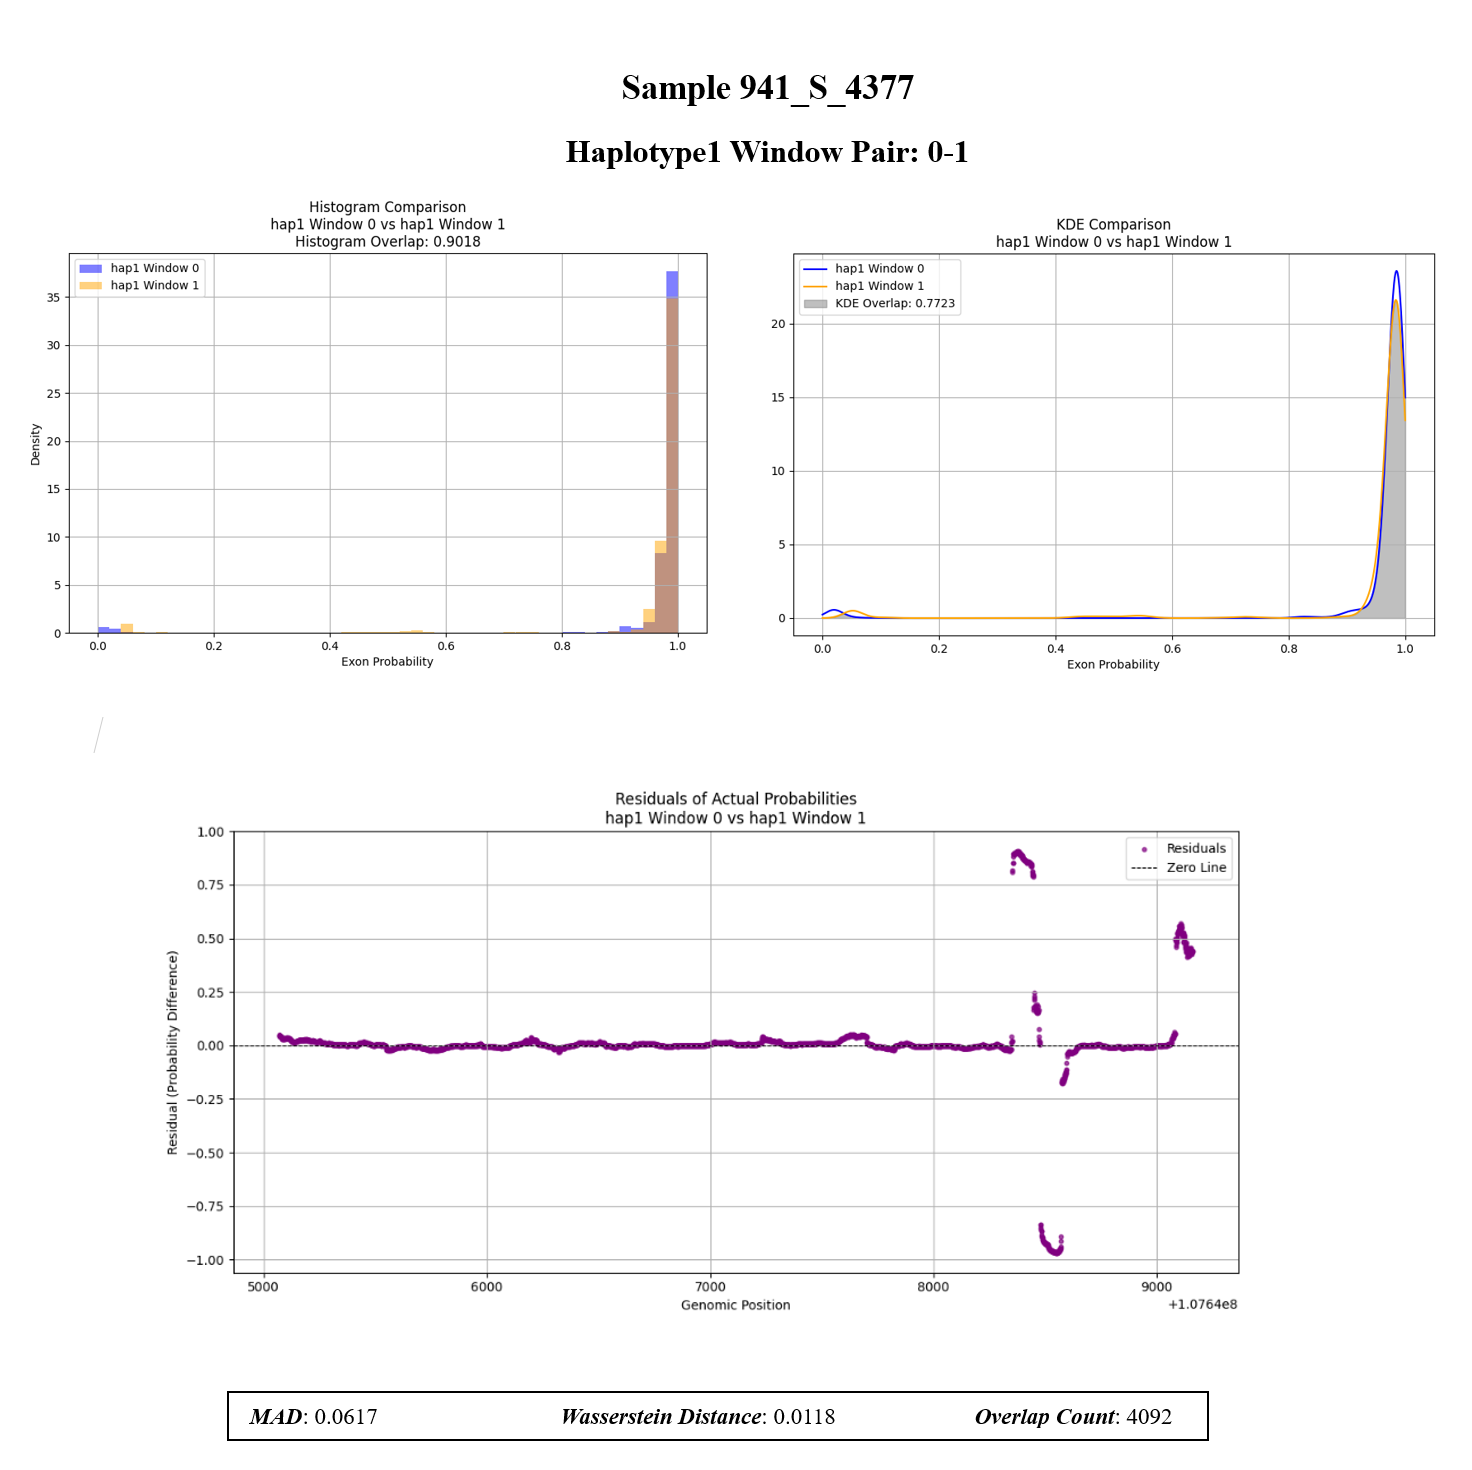
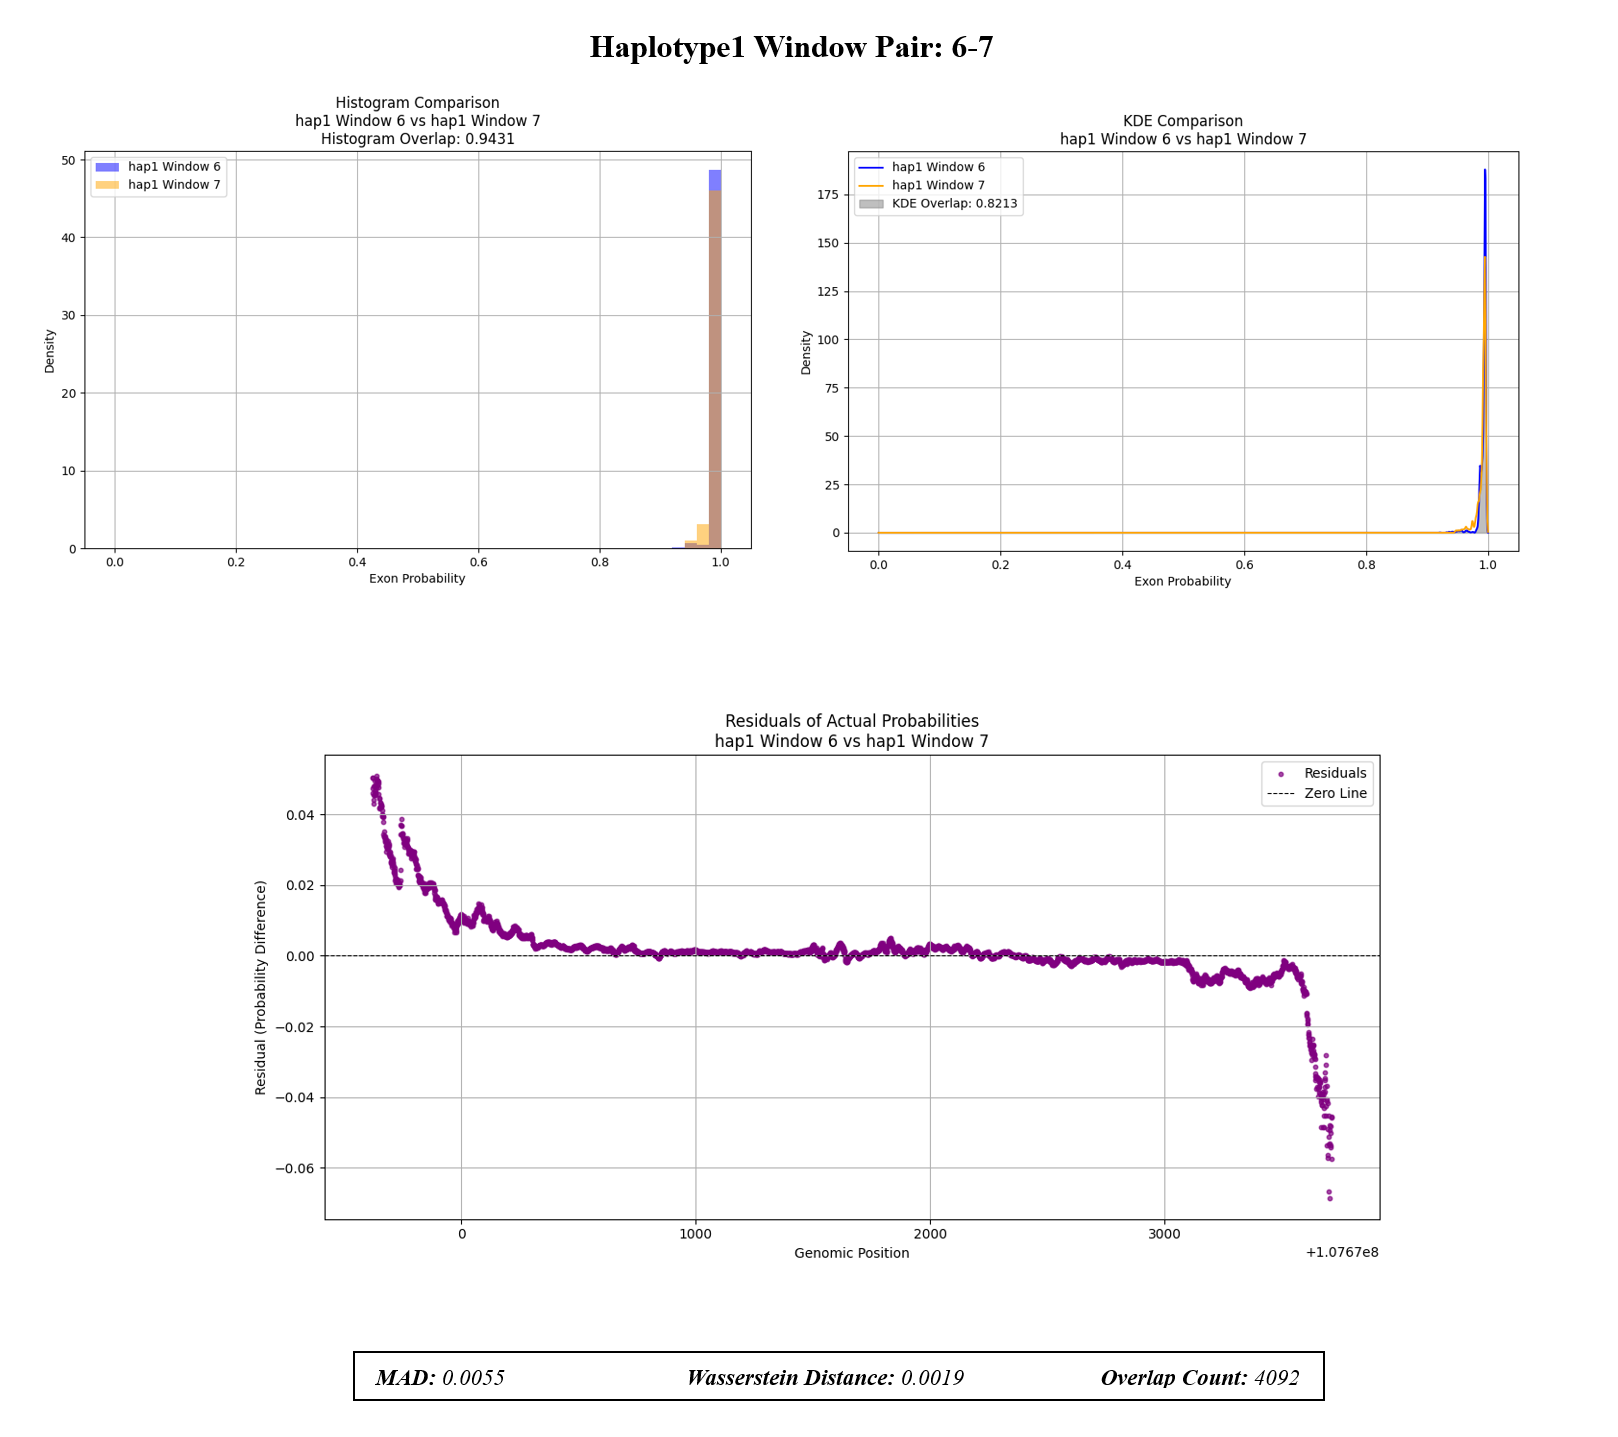
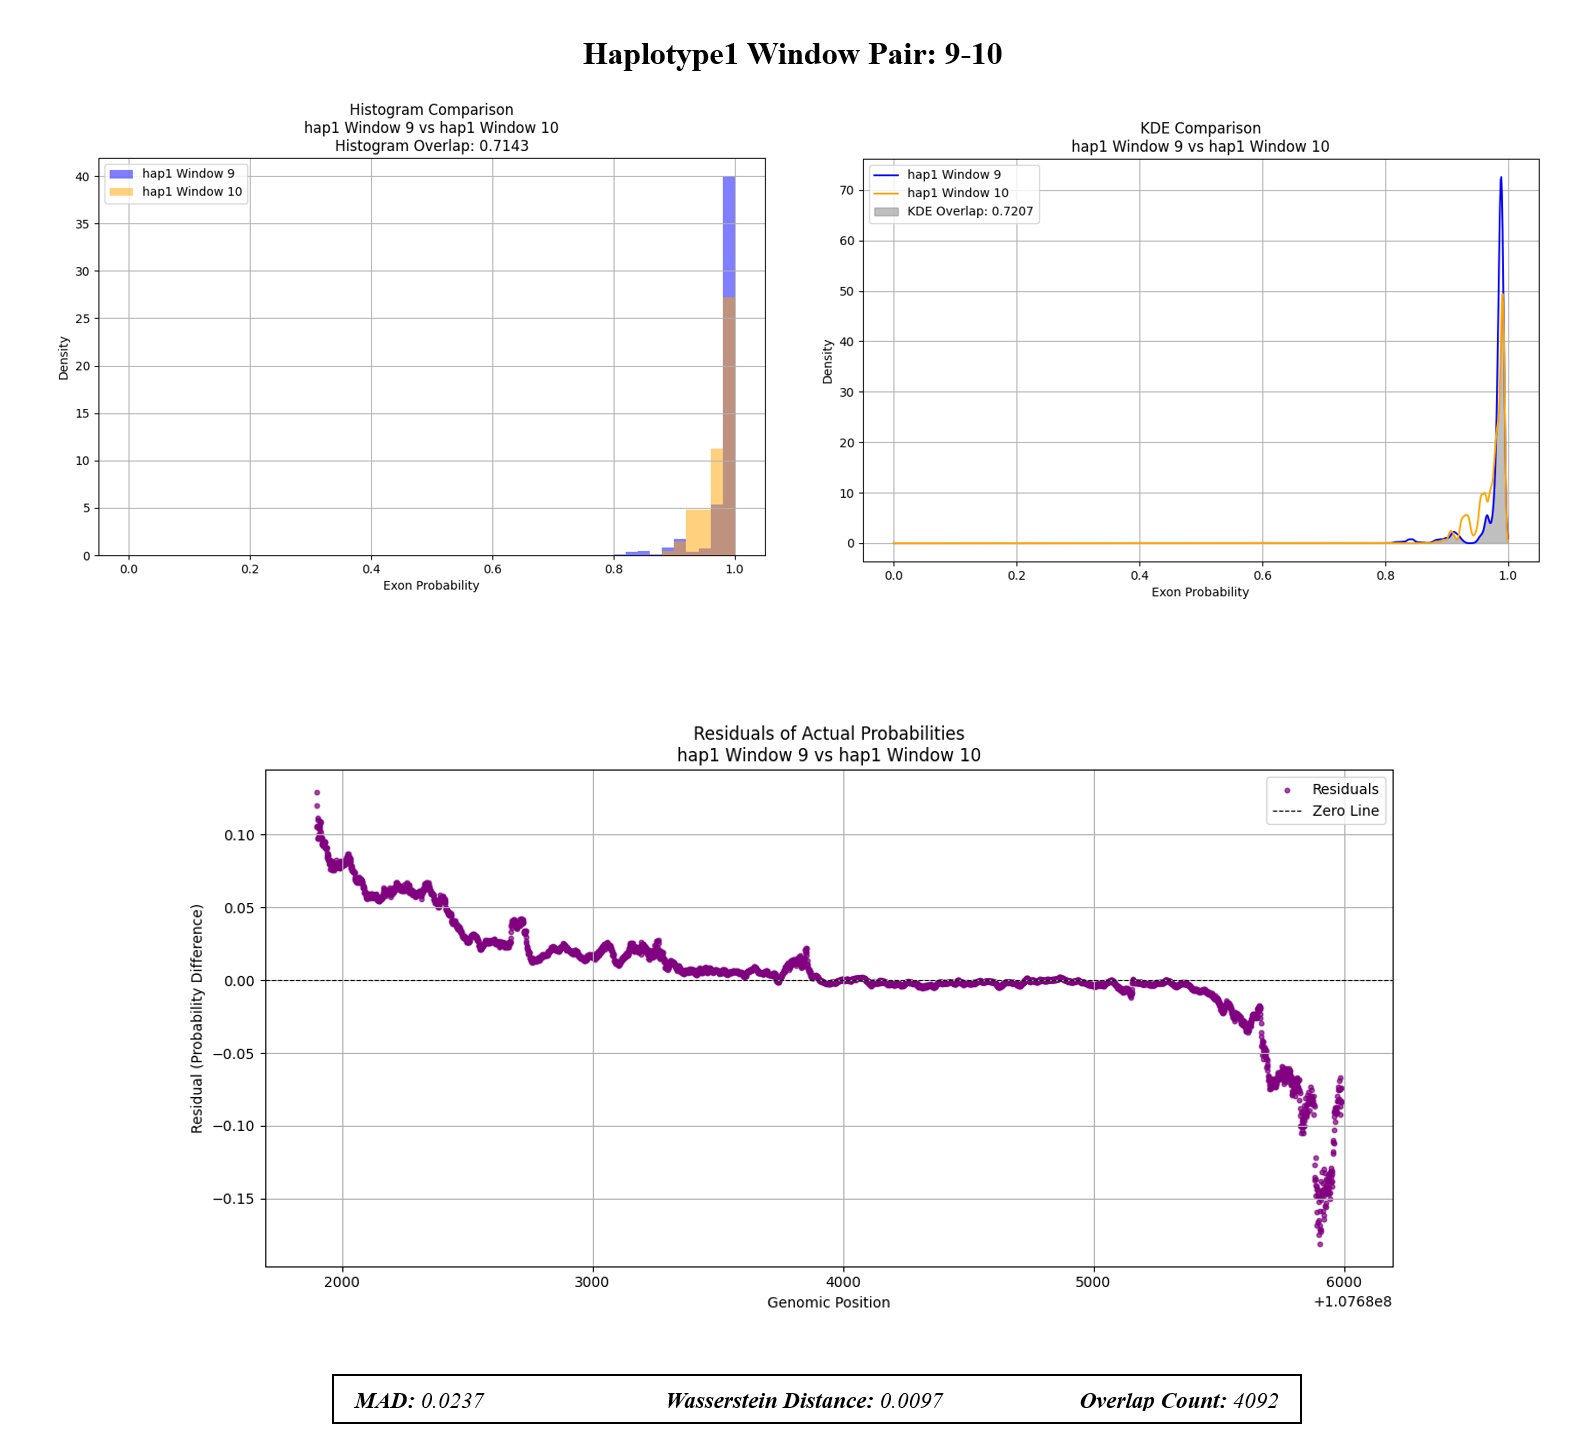

#### Sample 941_S_2377 haplotype 2

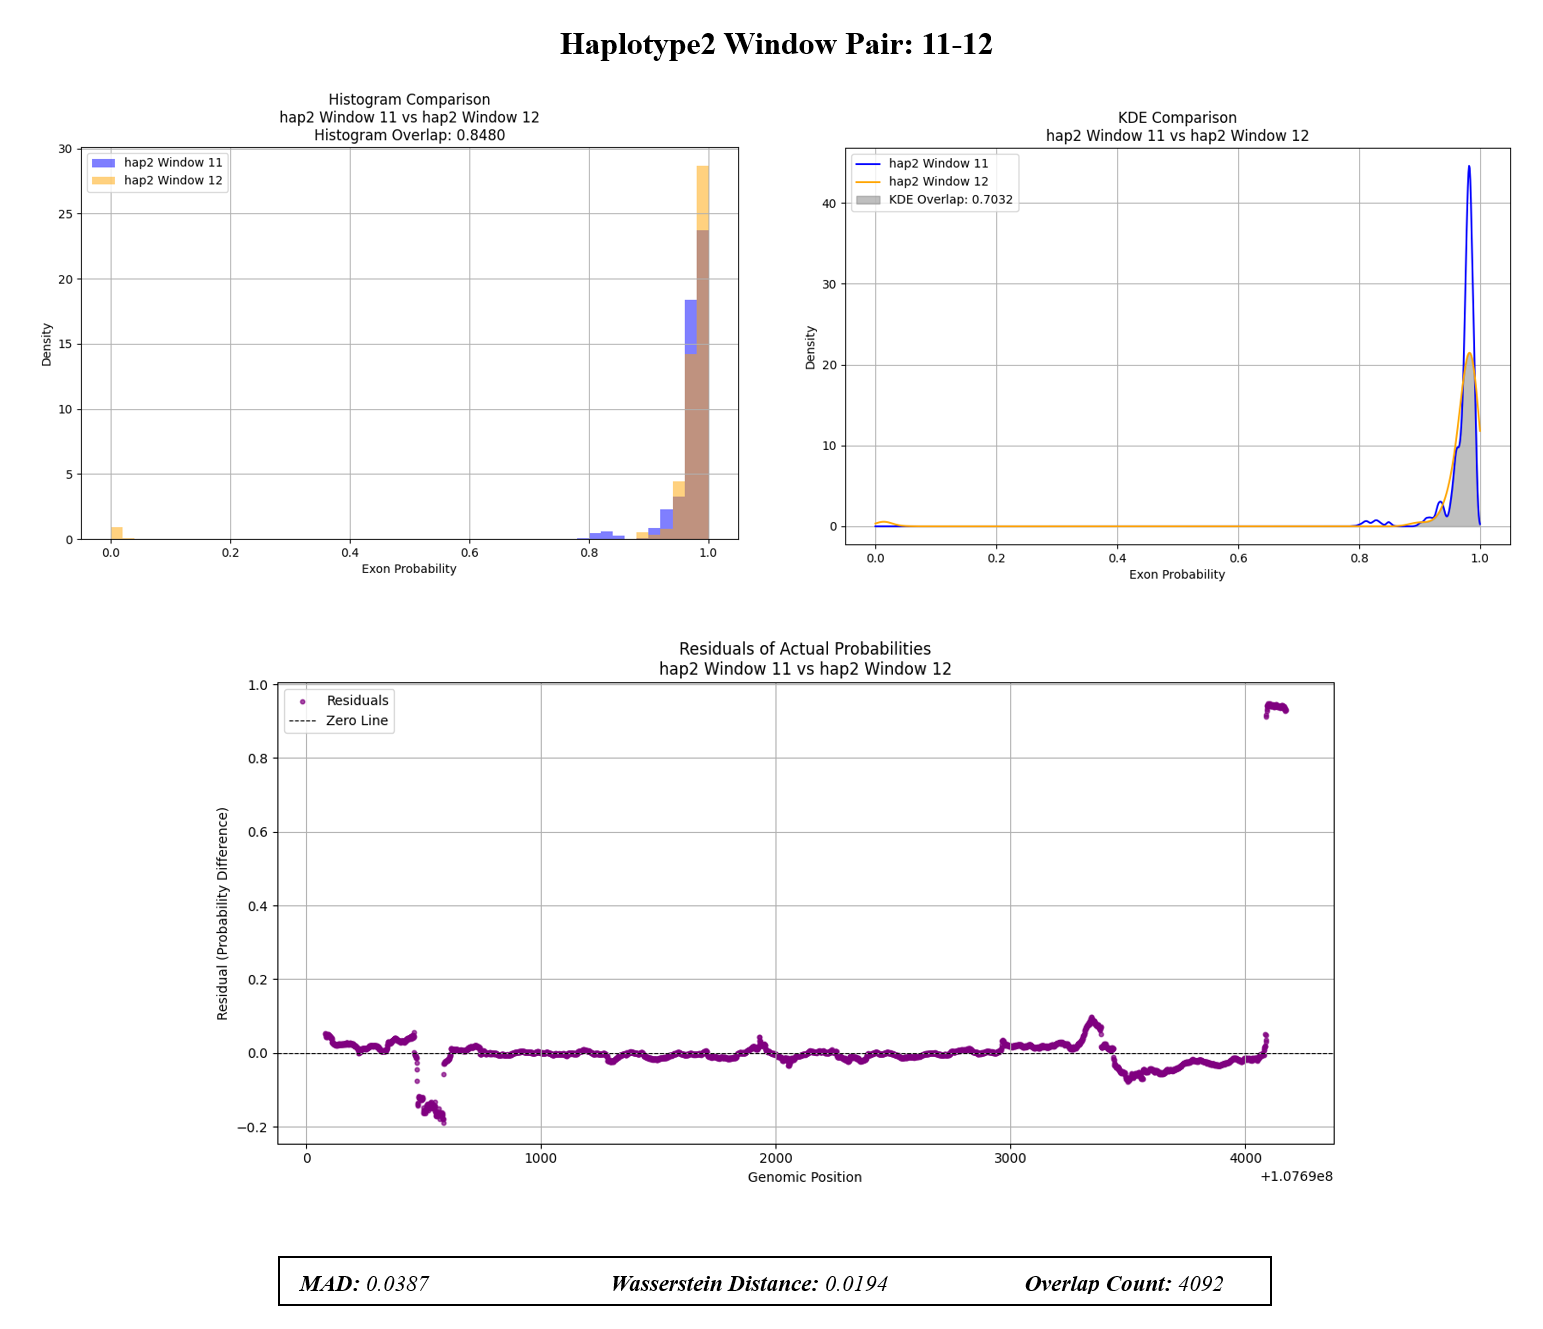
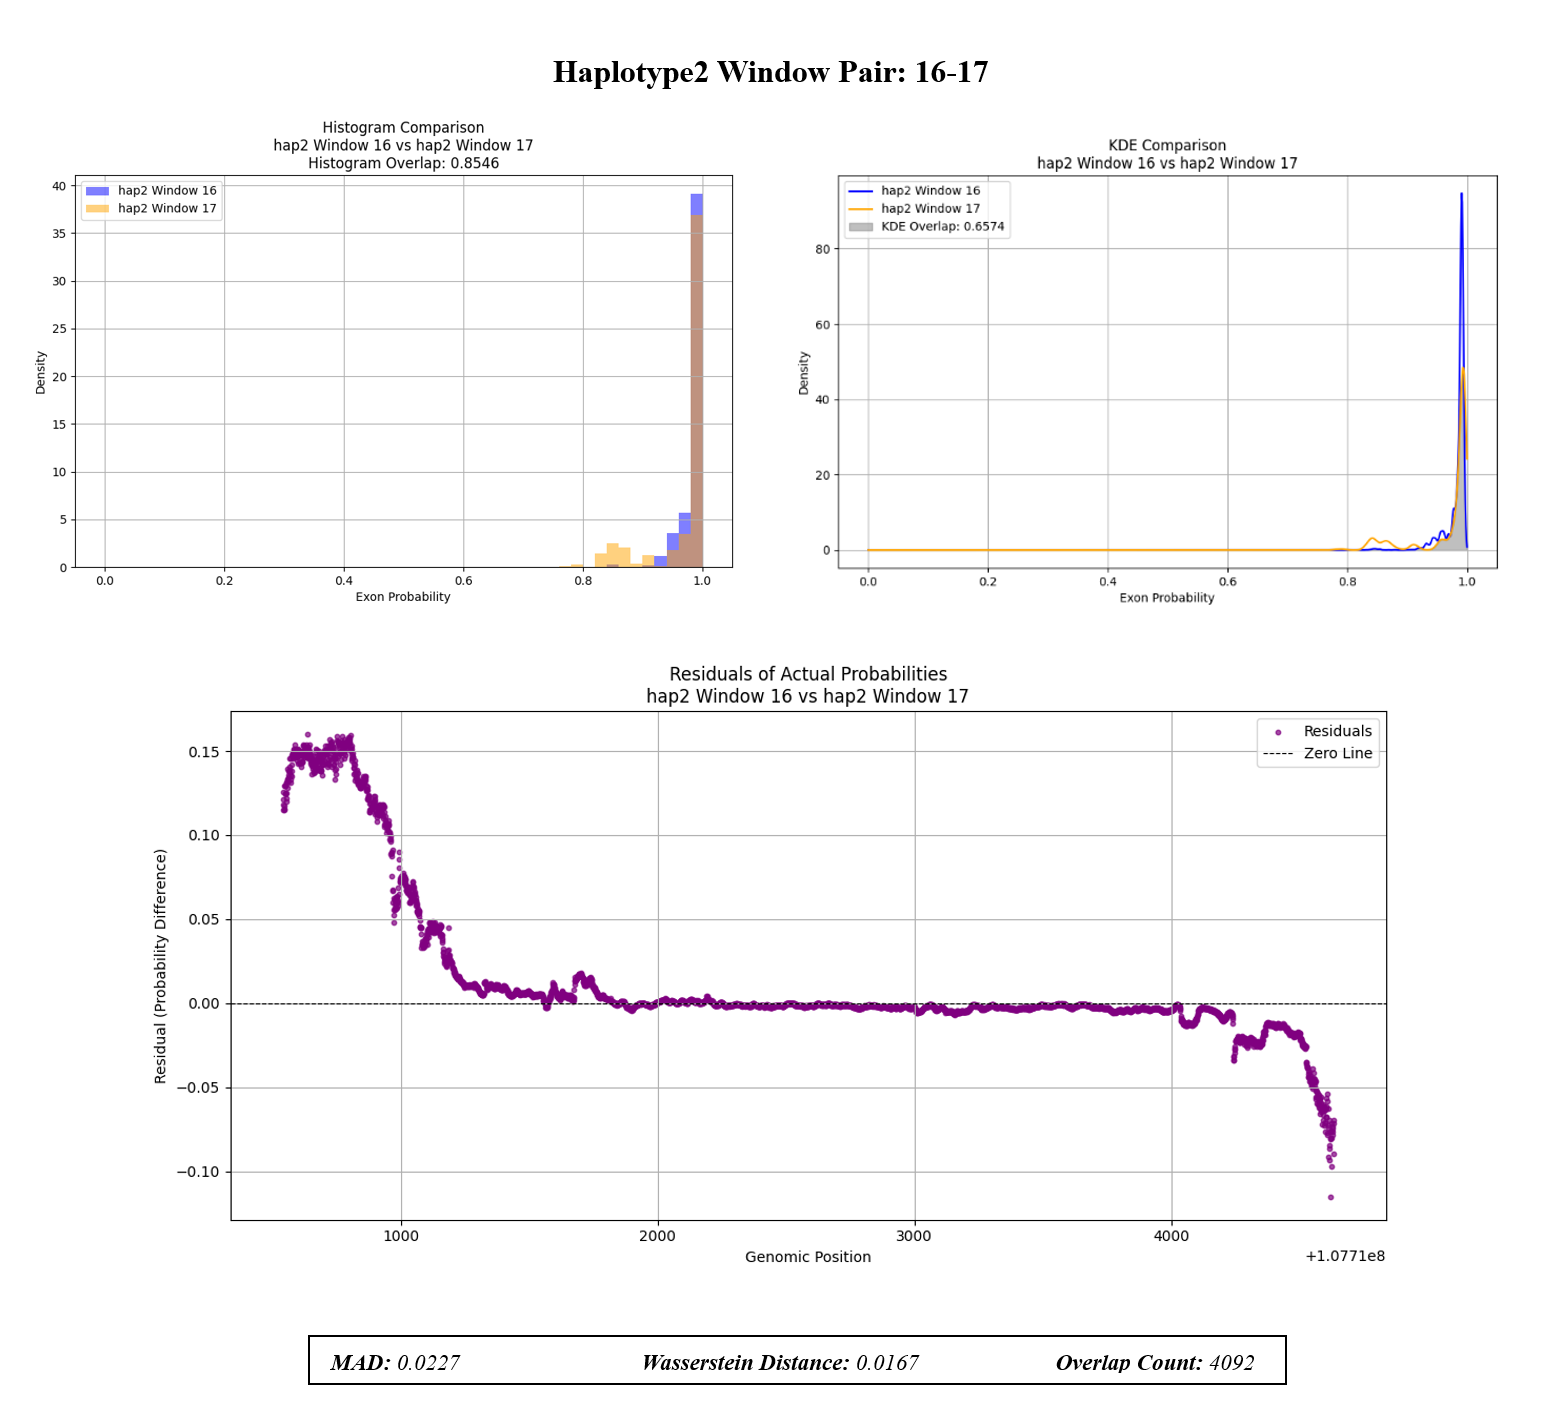
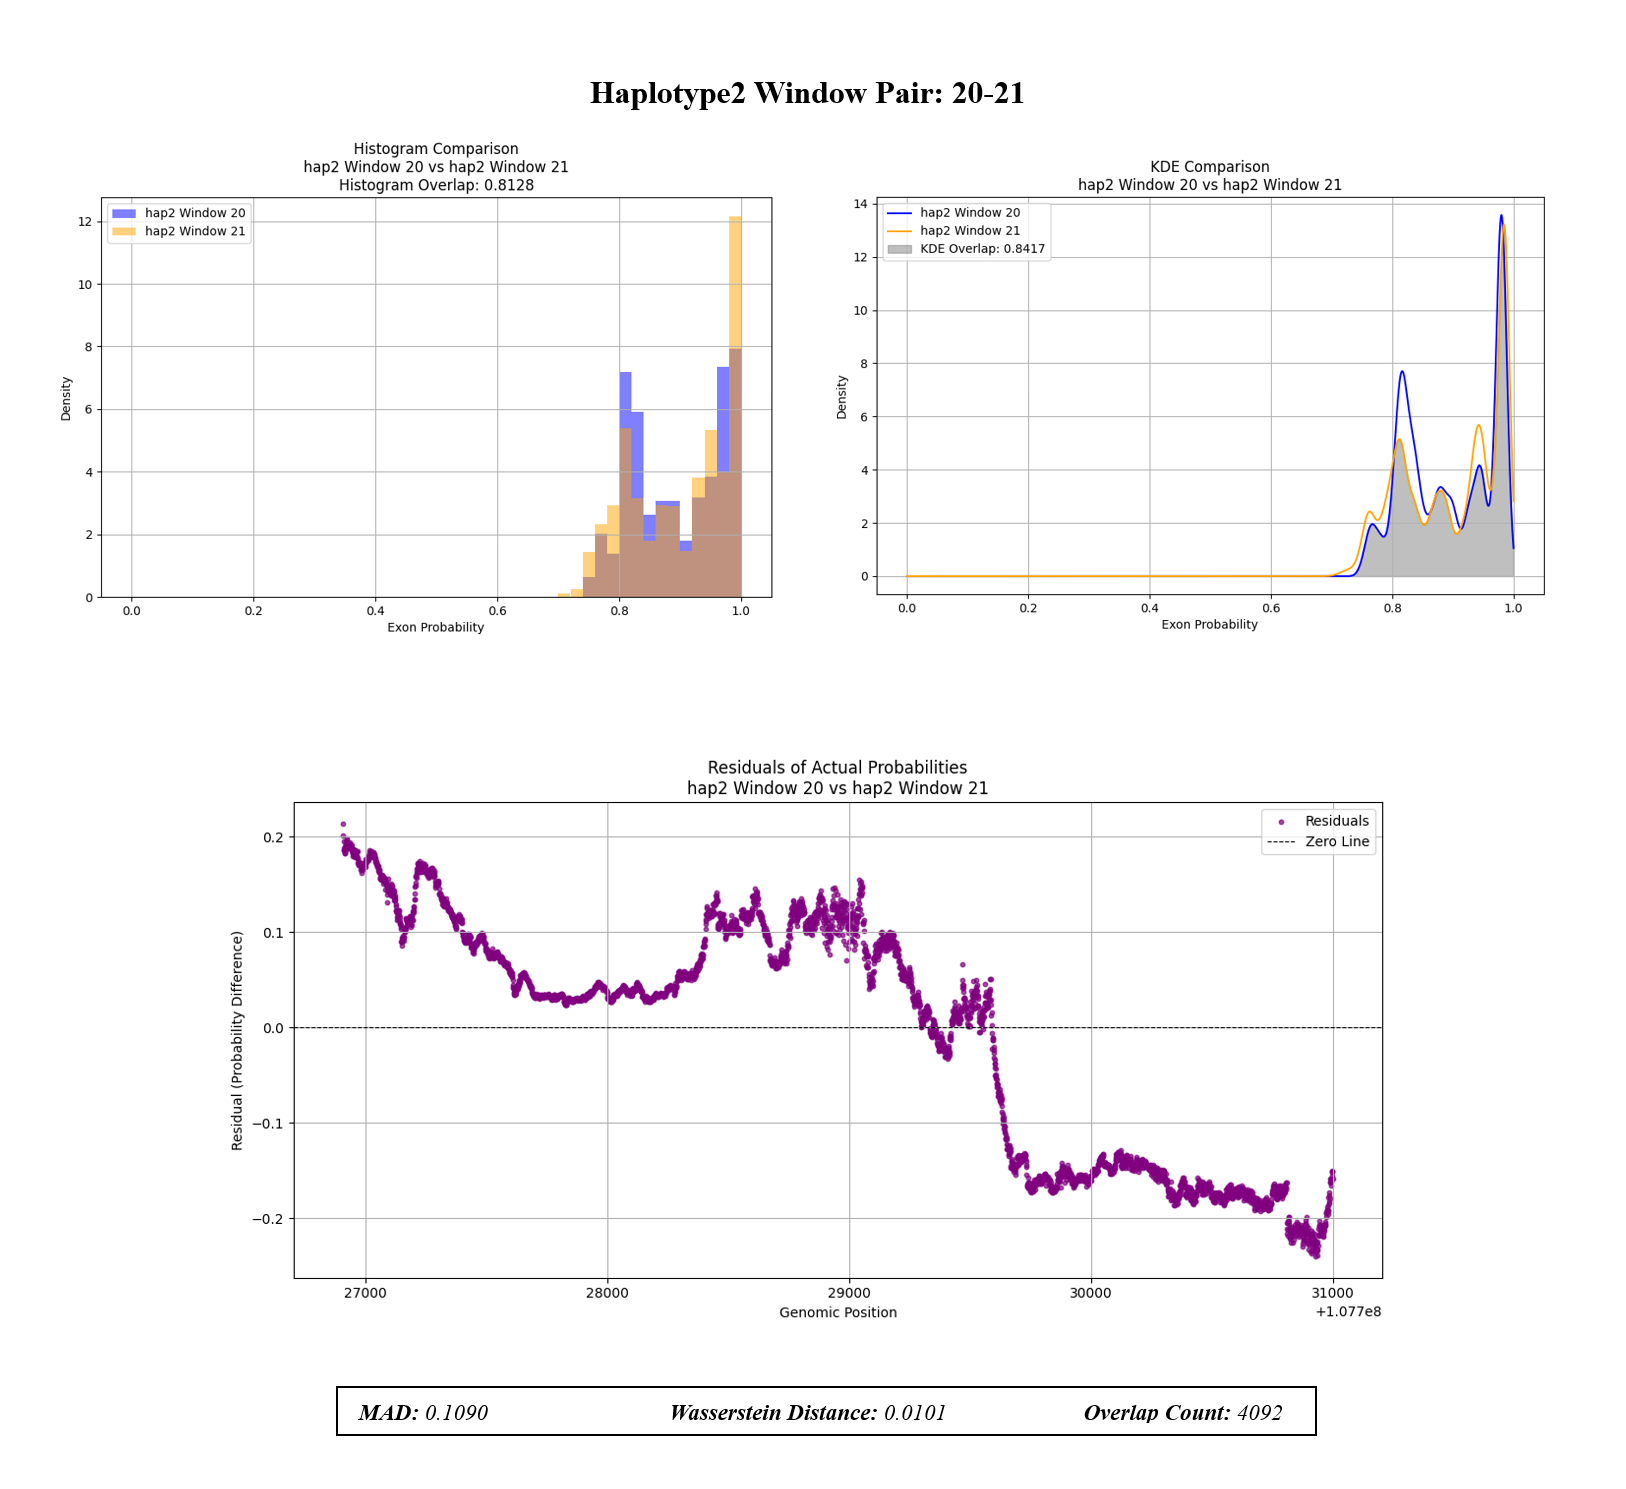

#### Sample 941_S_4376 haplotype 1

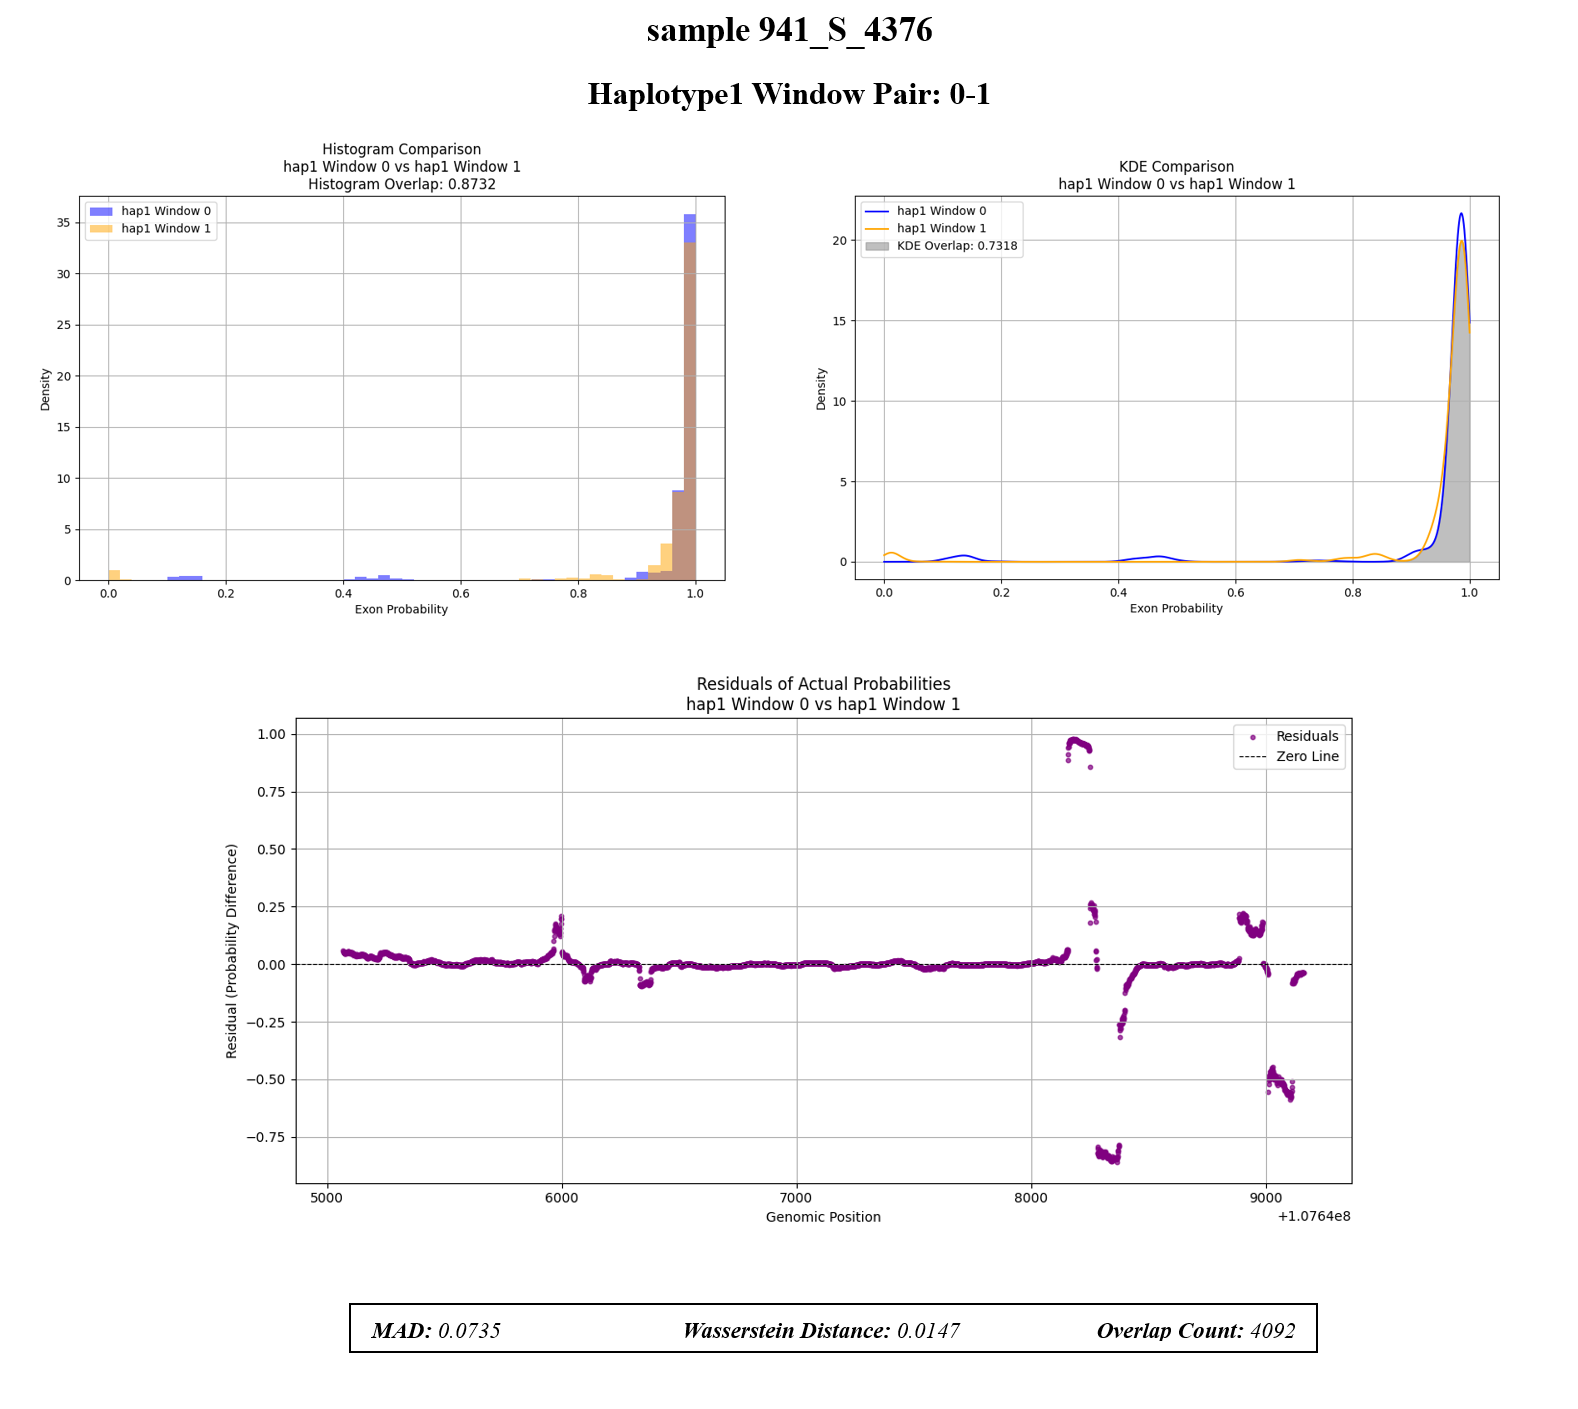
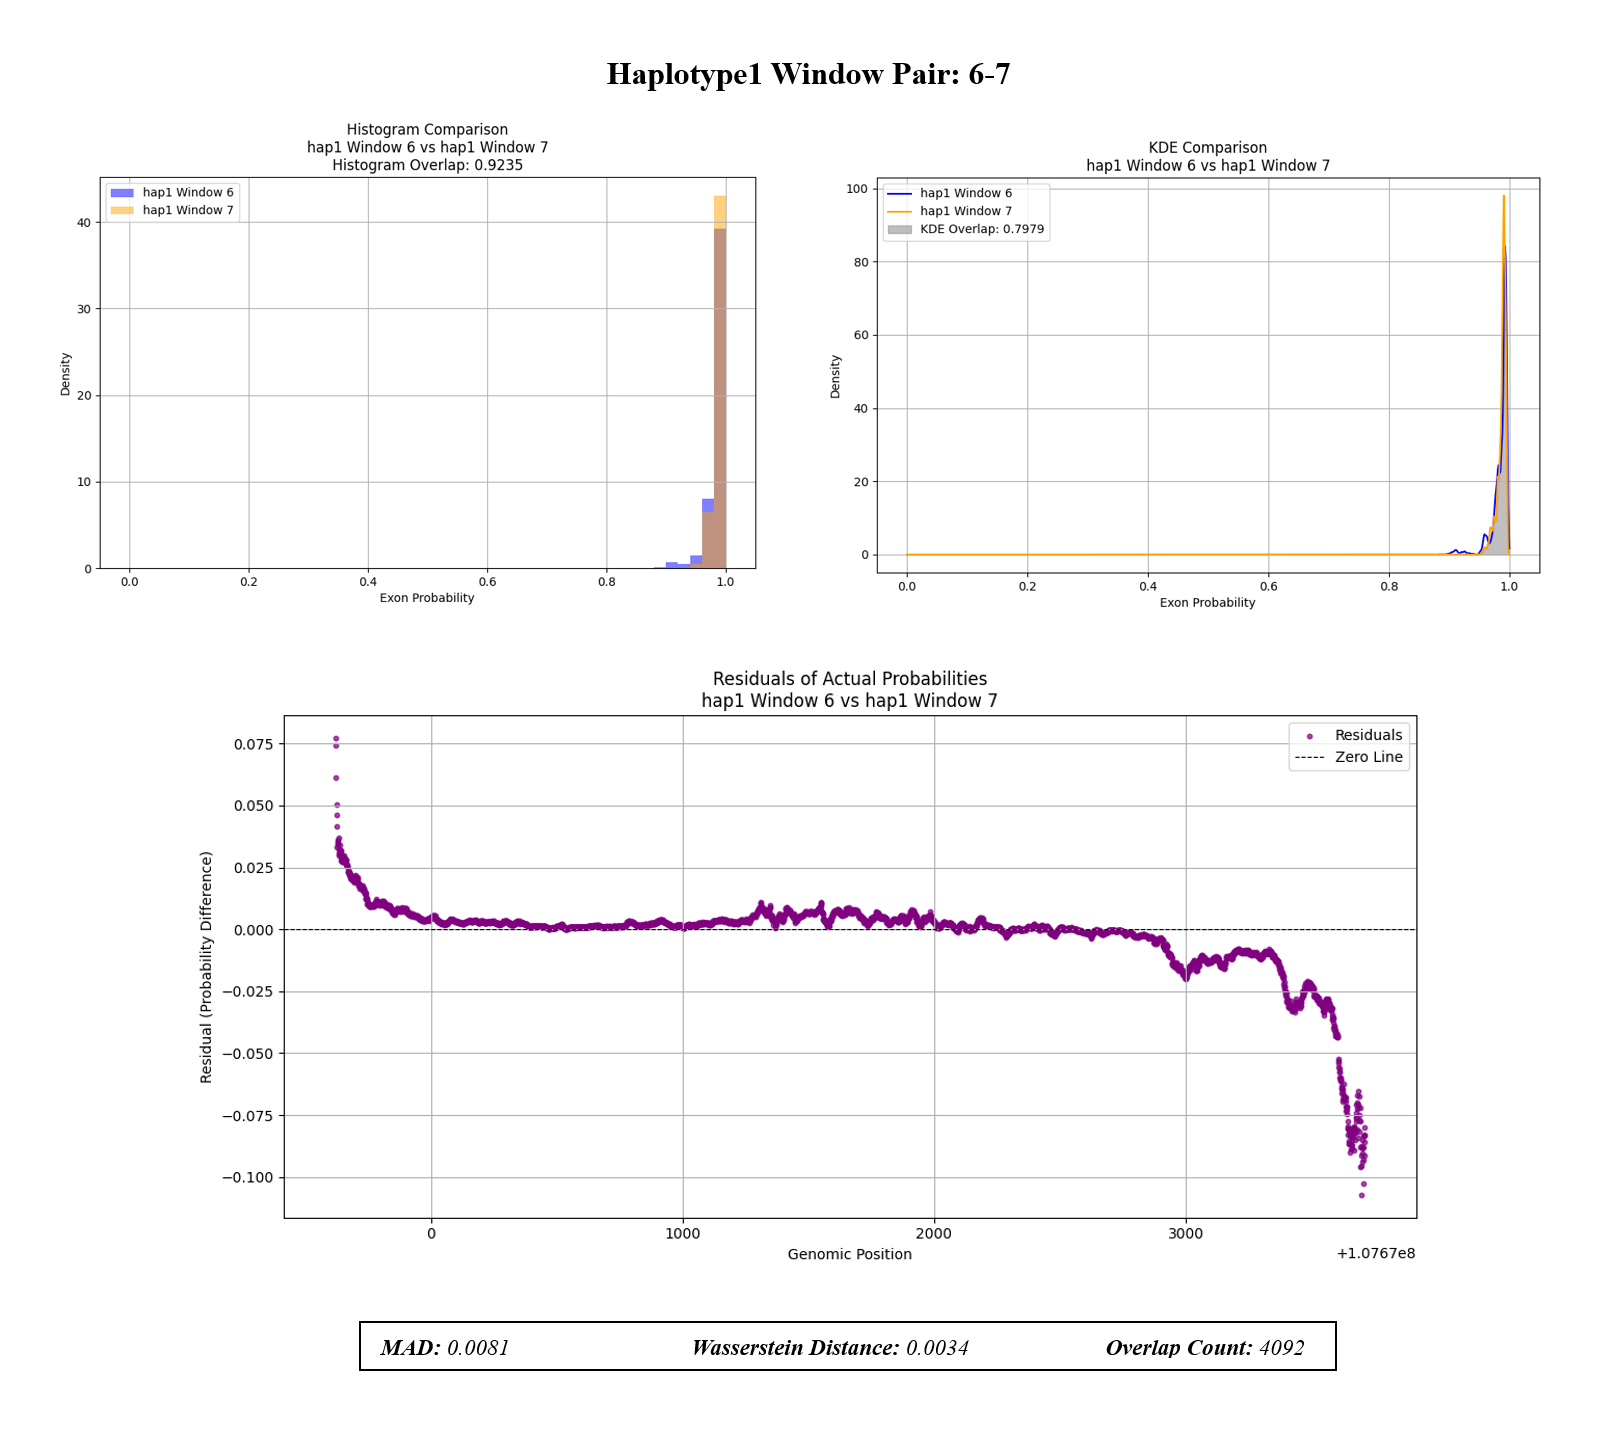
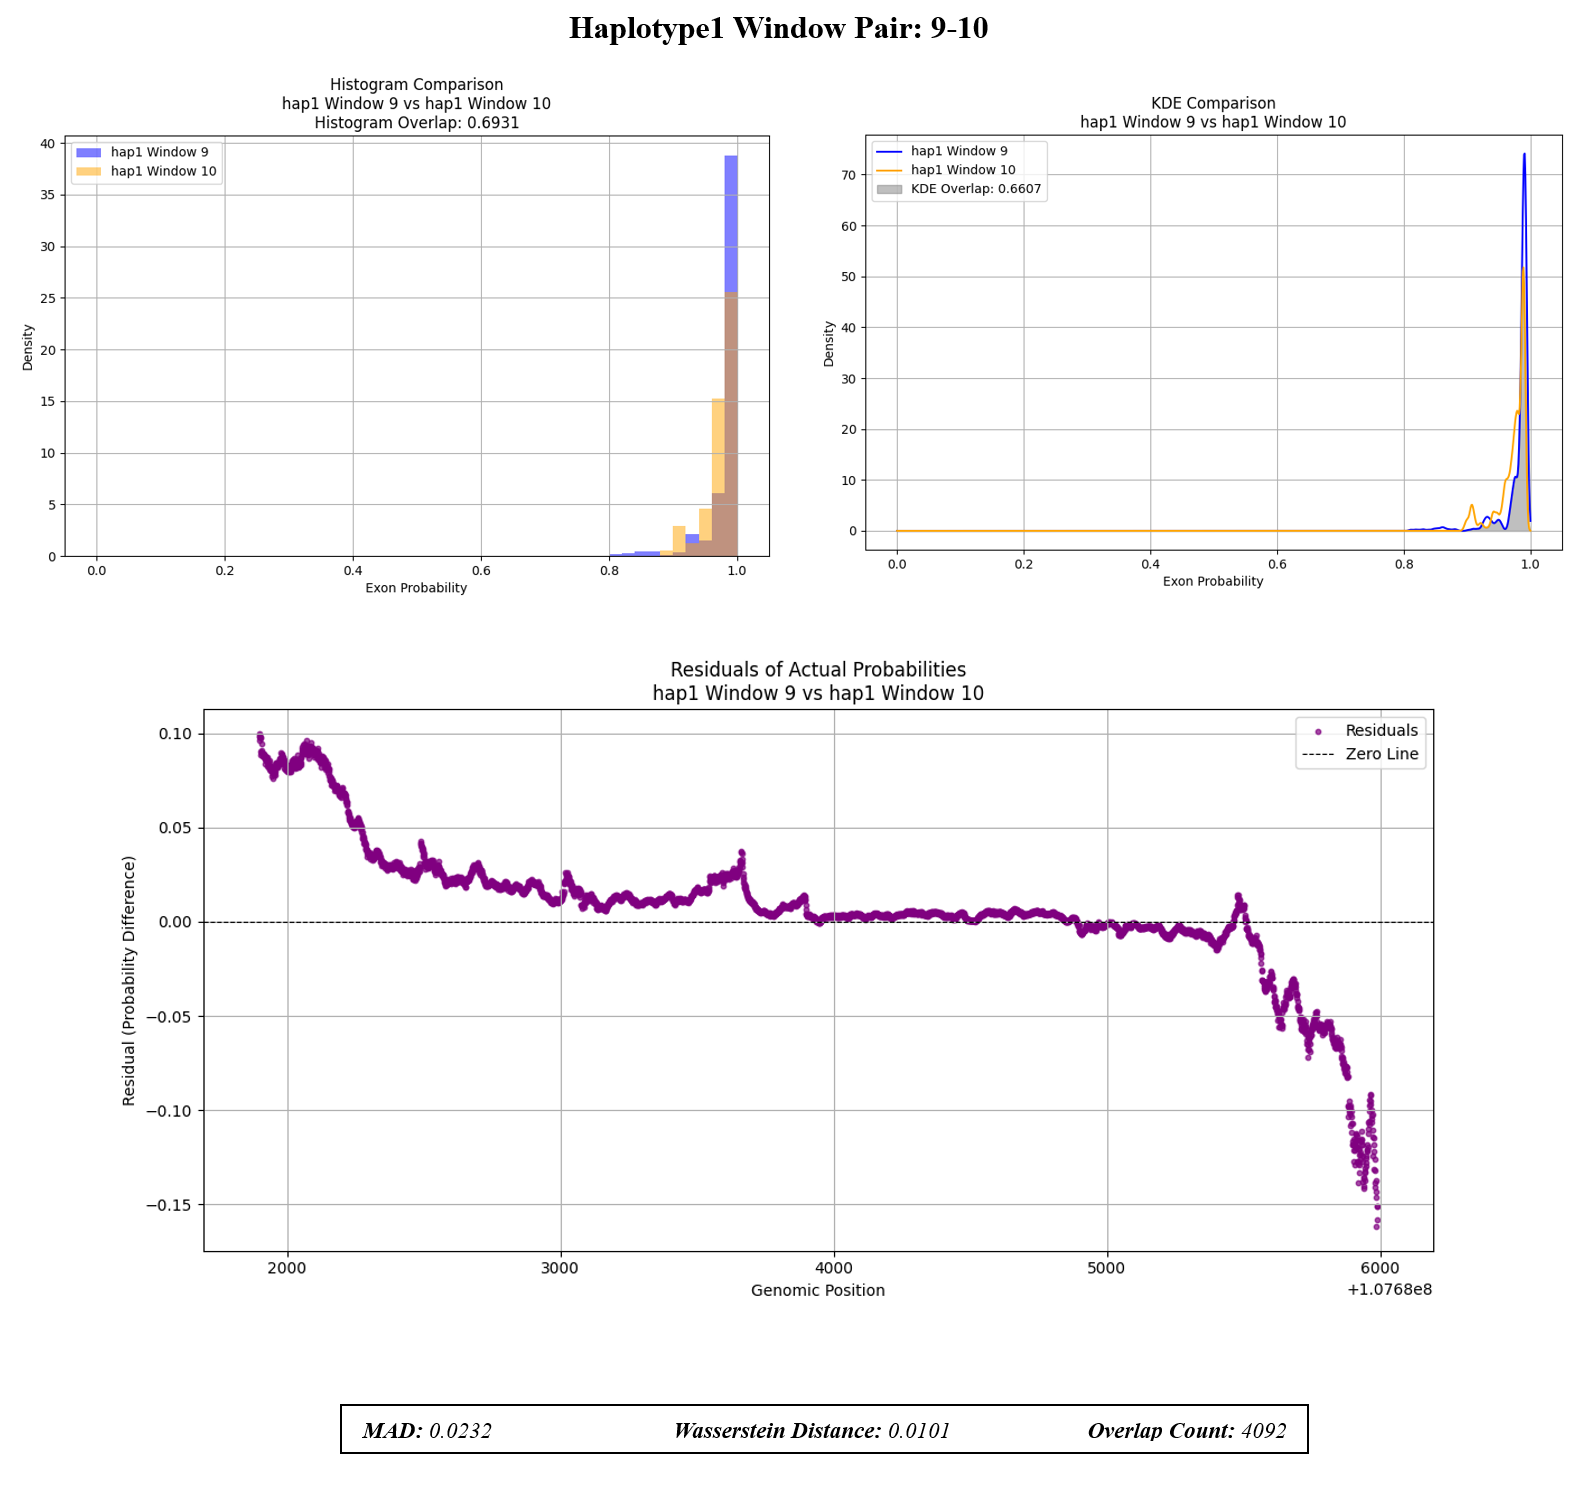

#### Sample 941_S_4376 haplotype 2

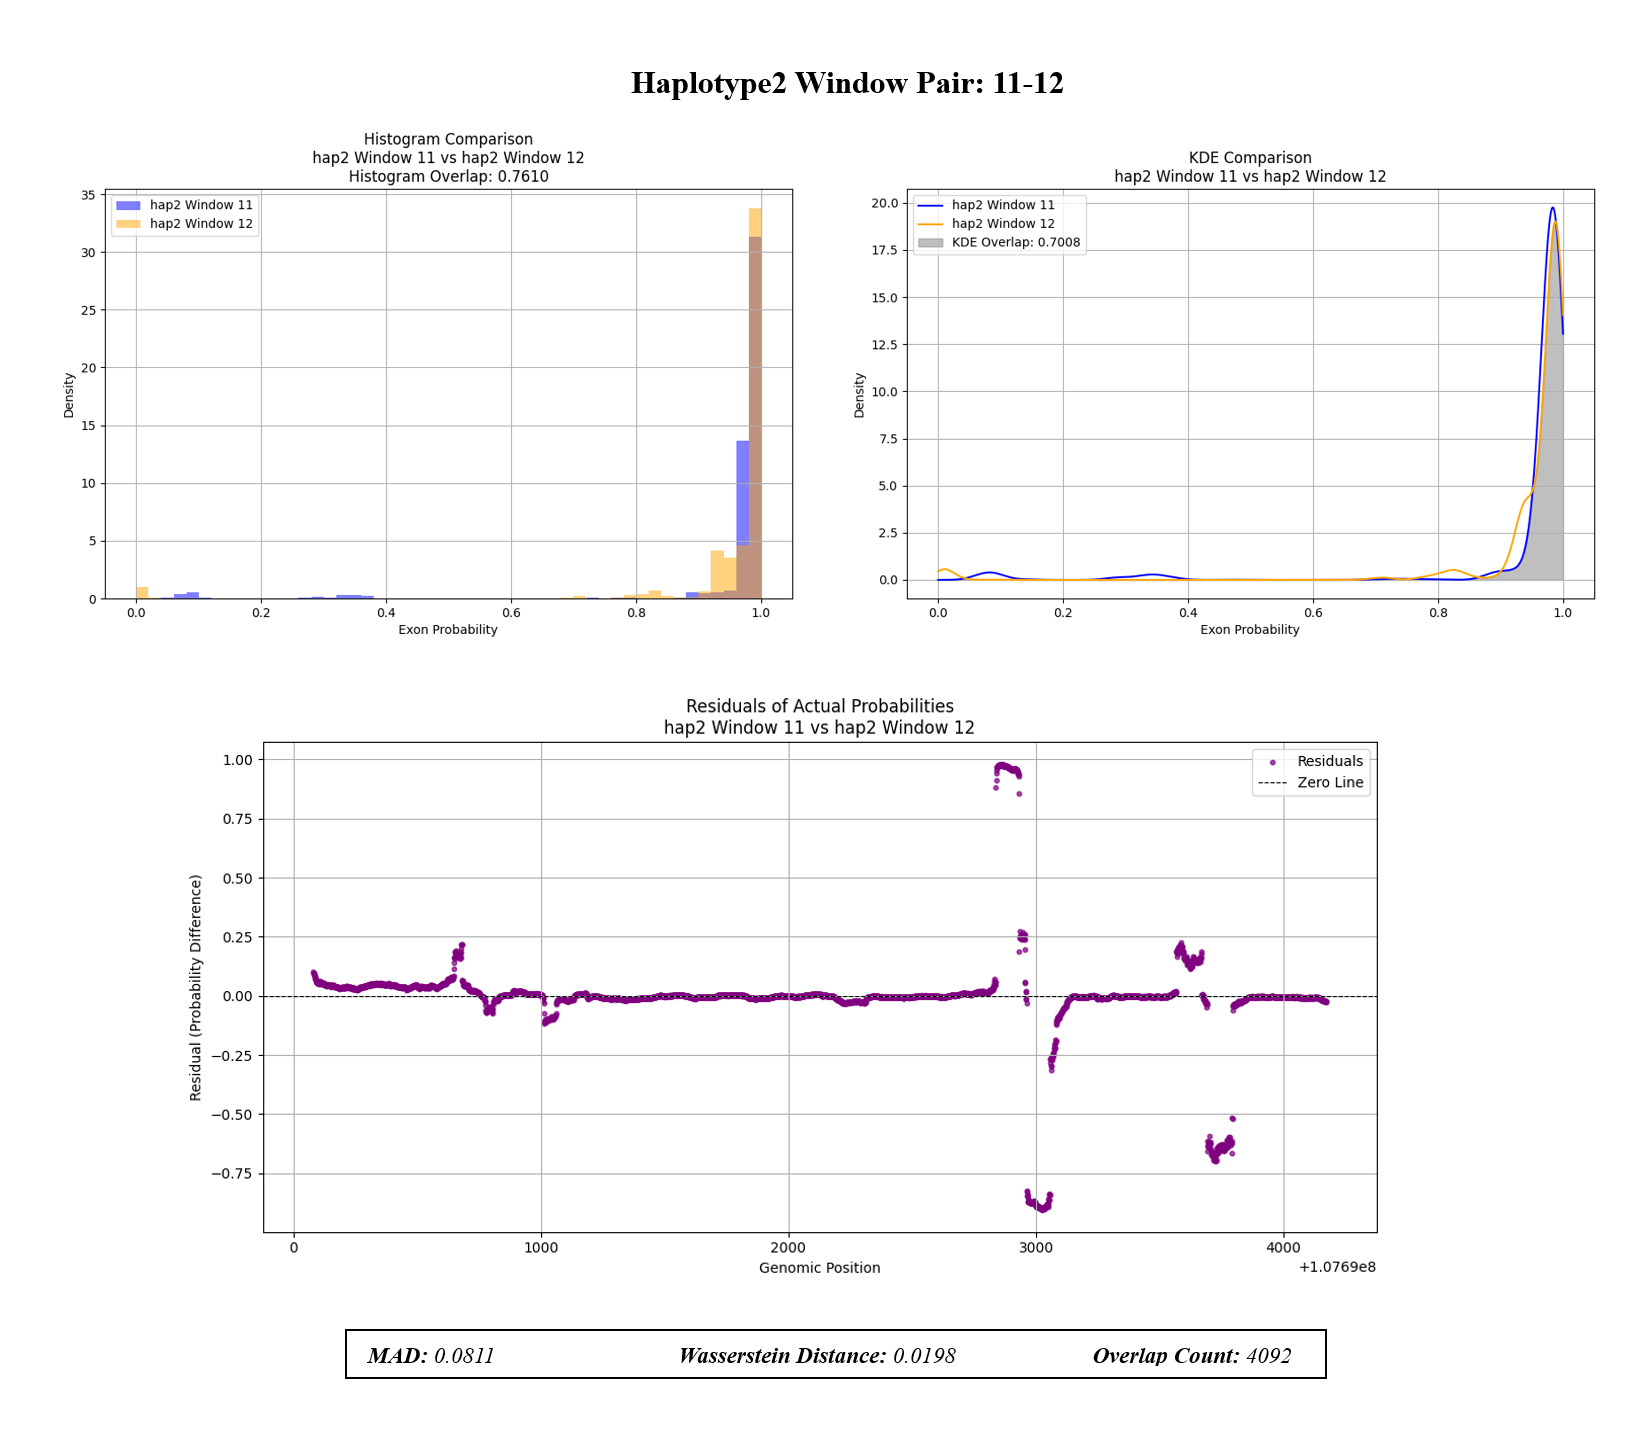
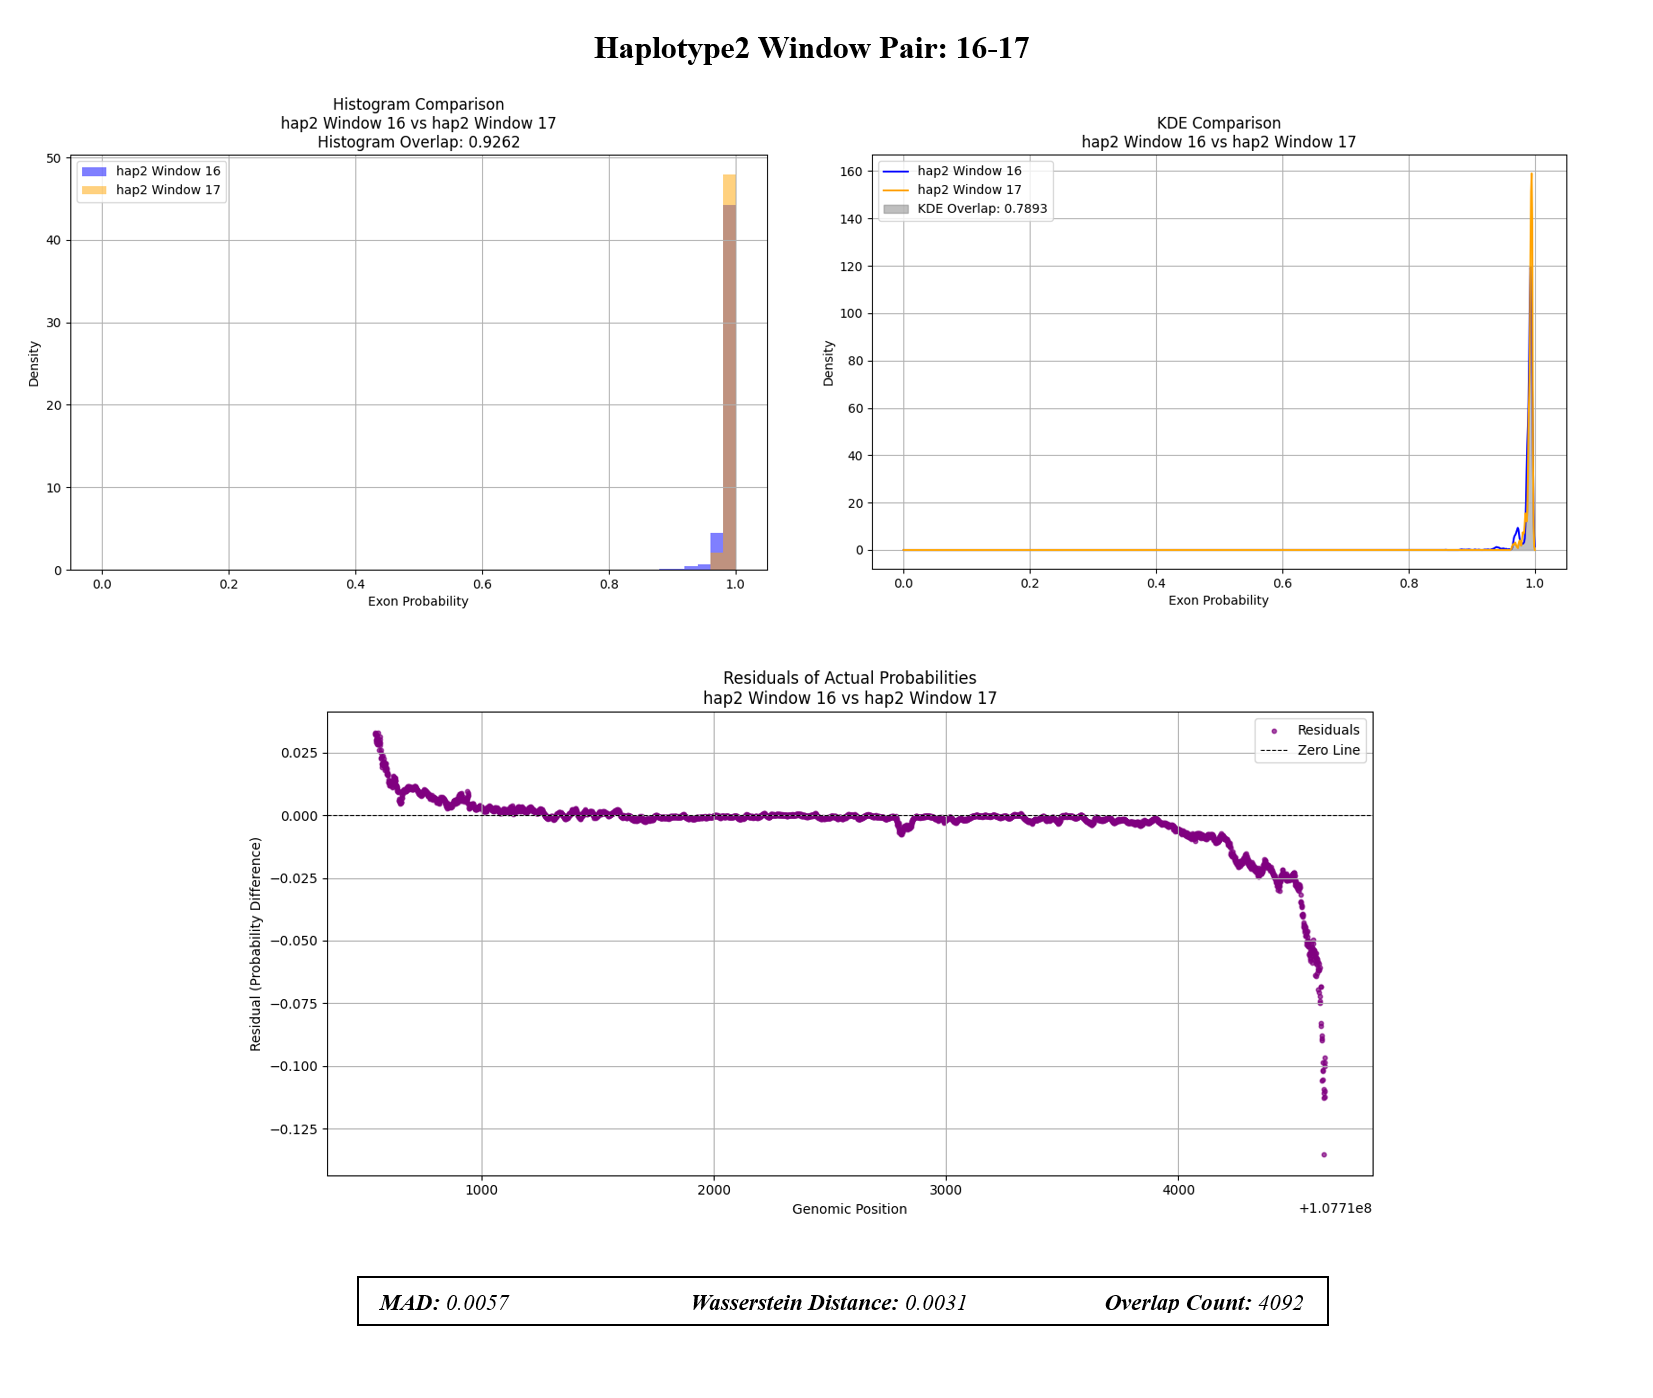
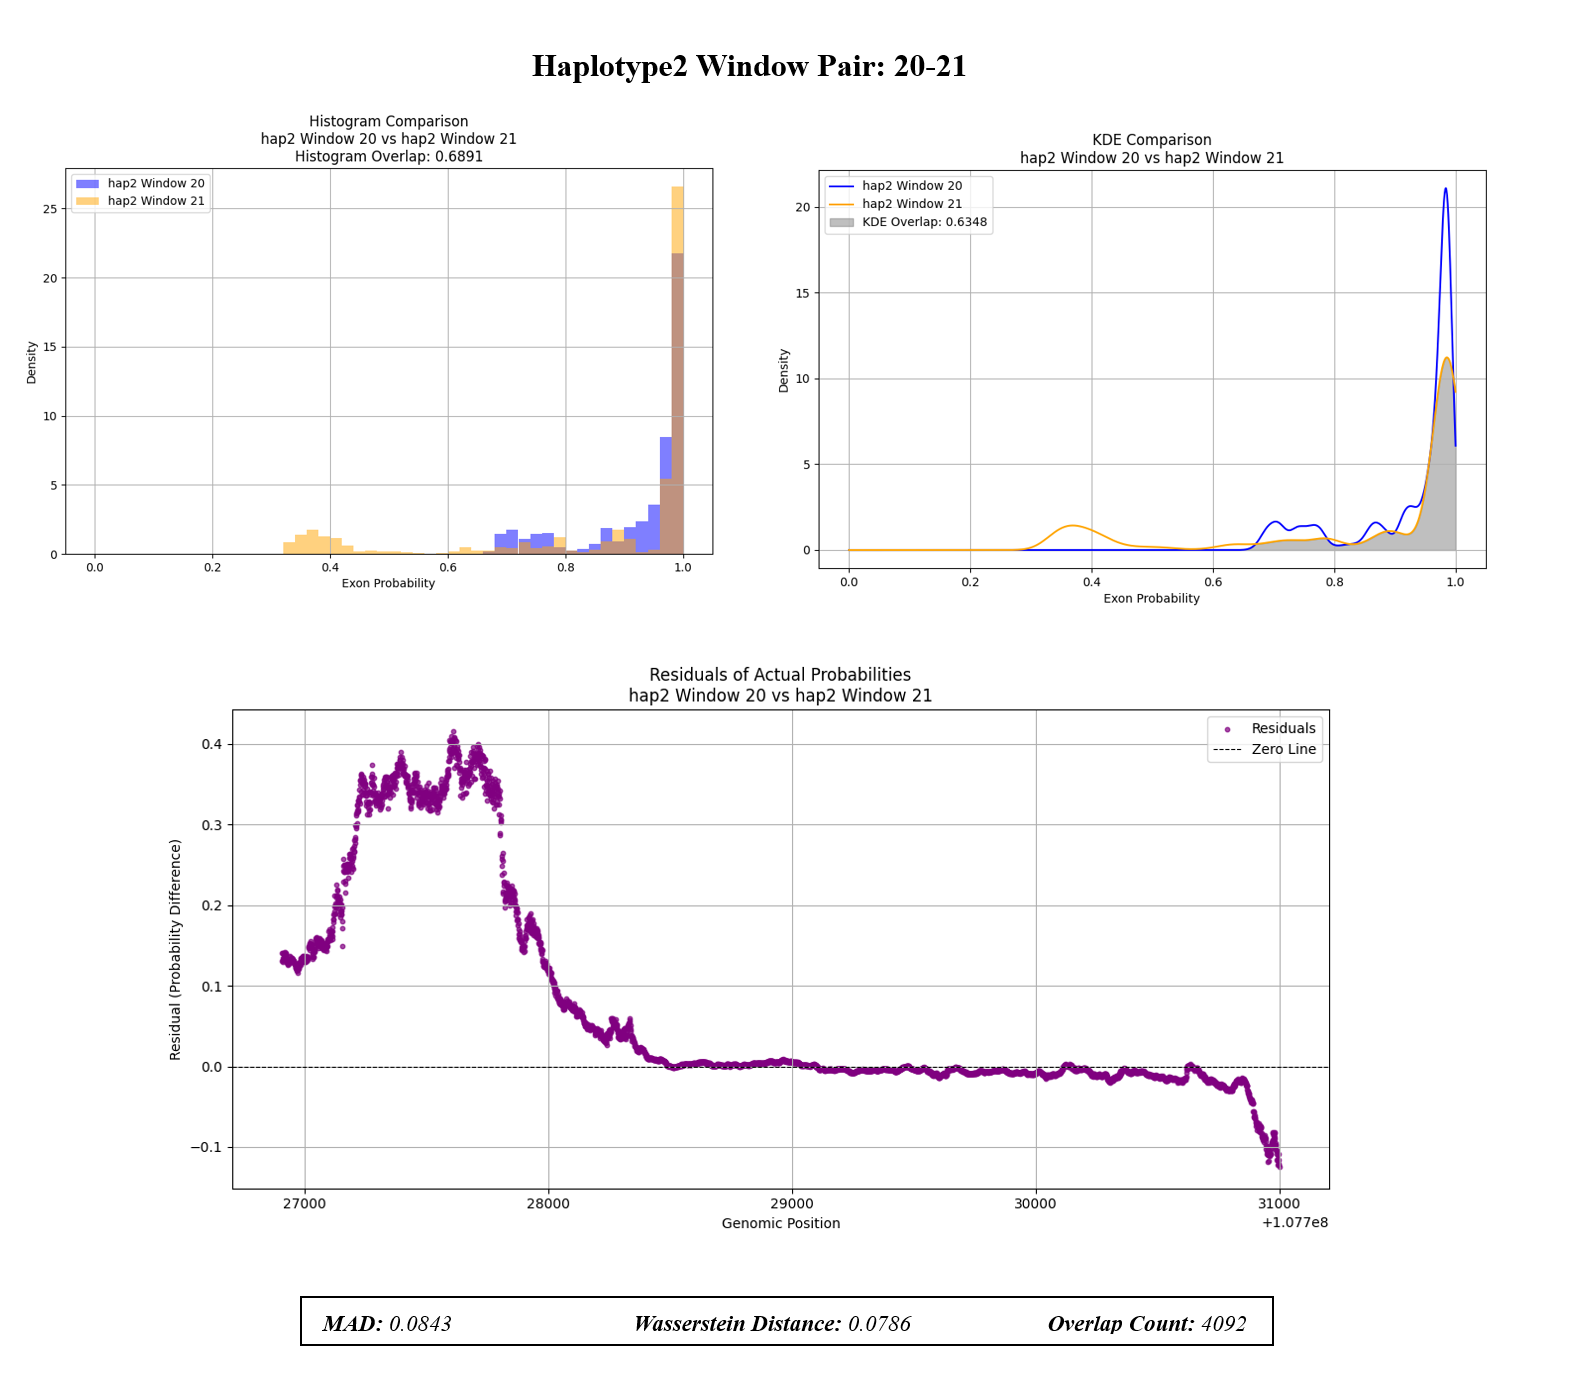

#### Sample 941_S_4420 haplotype 1

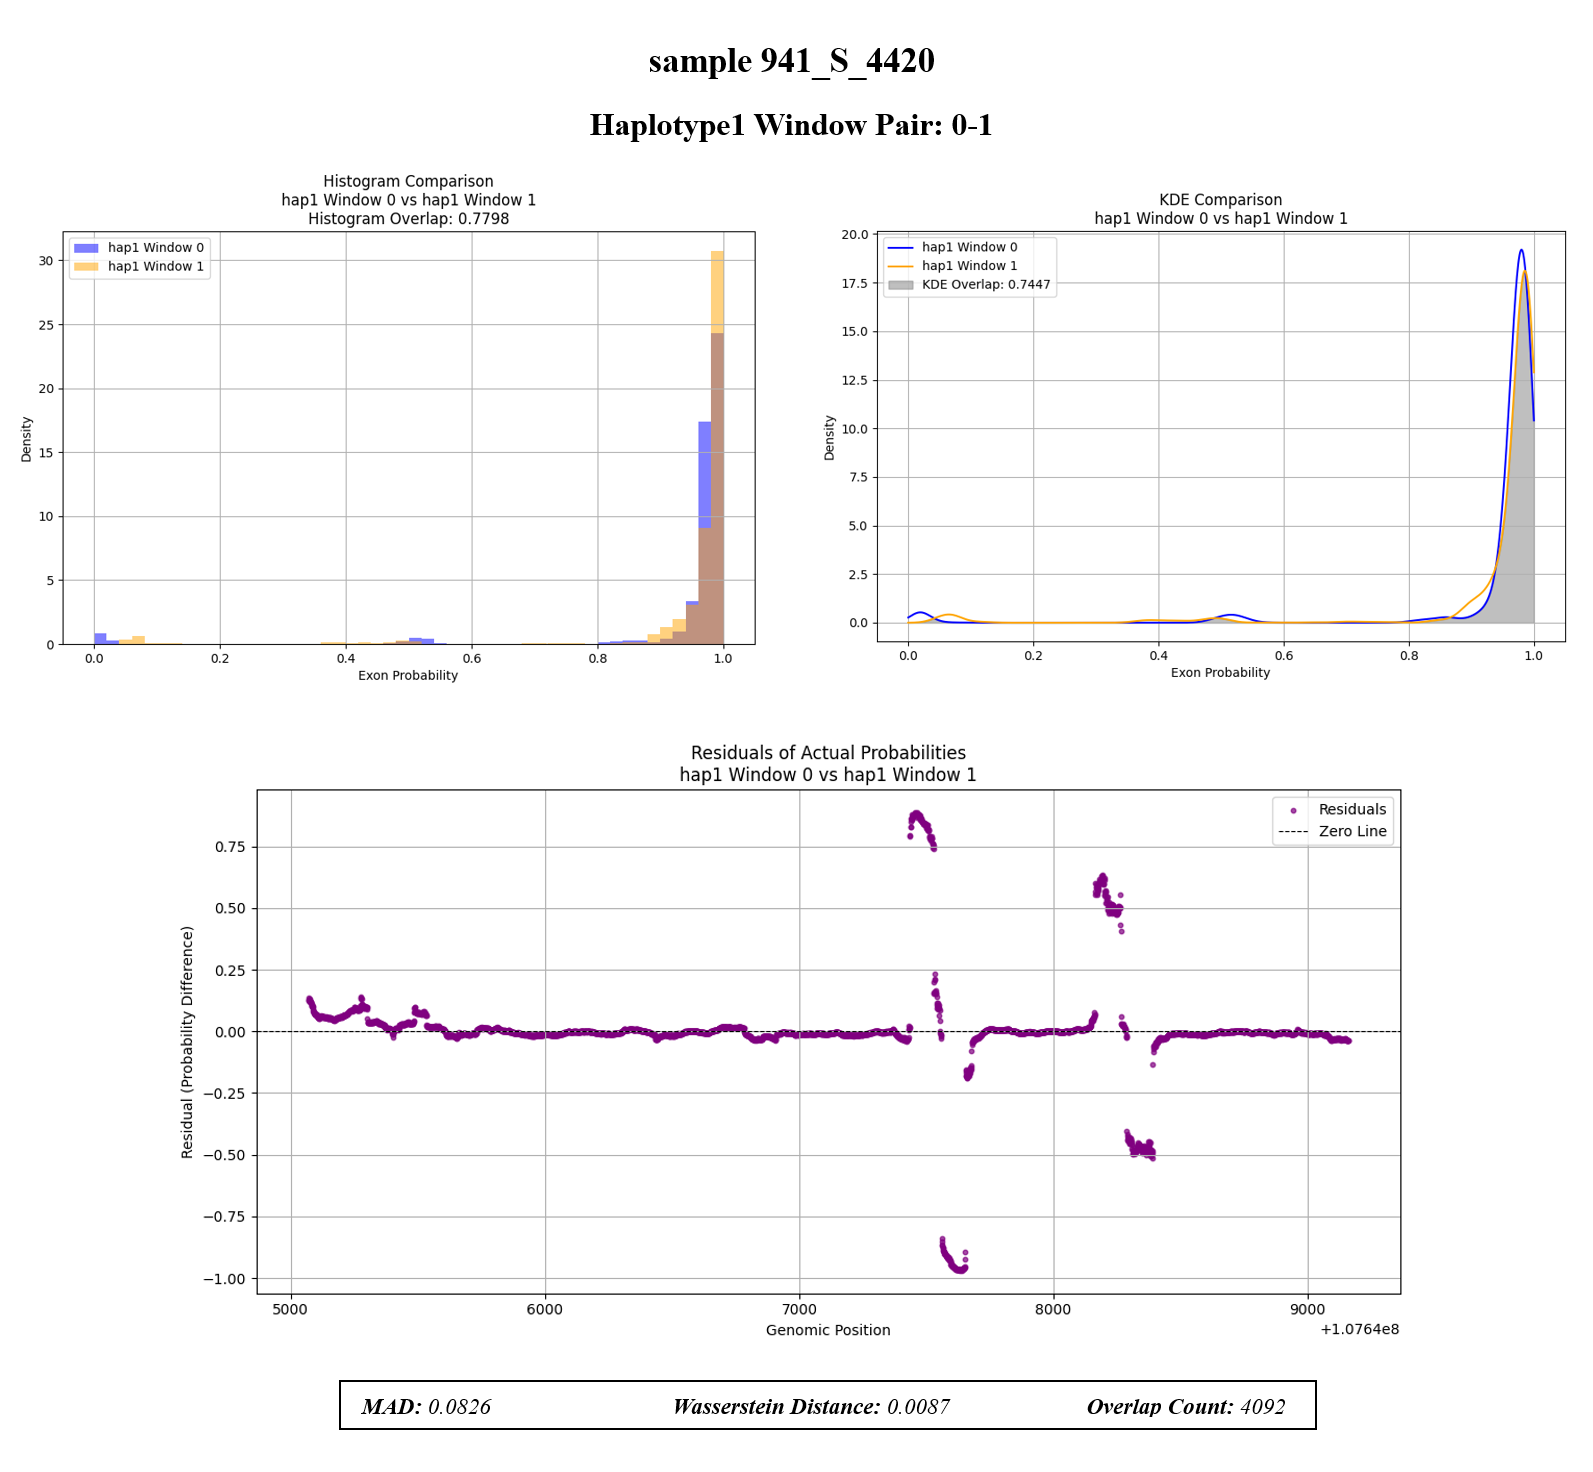
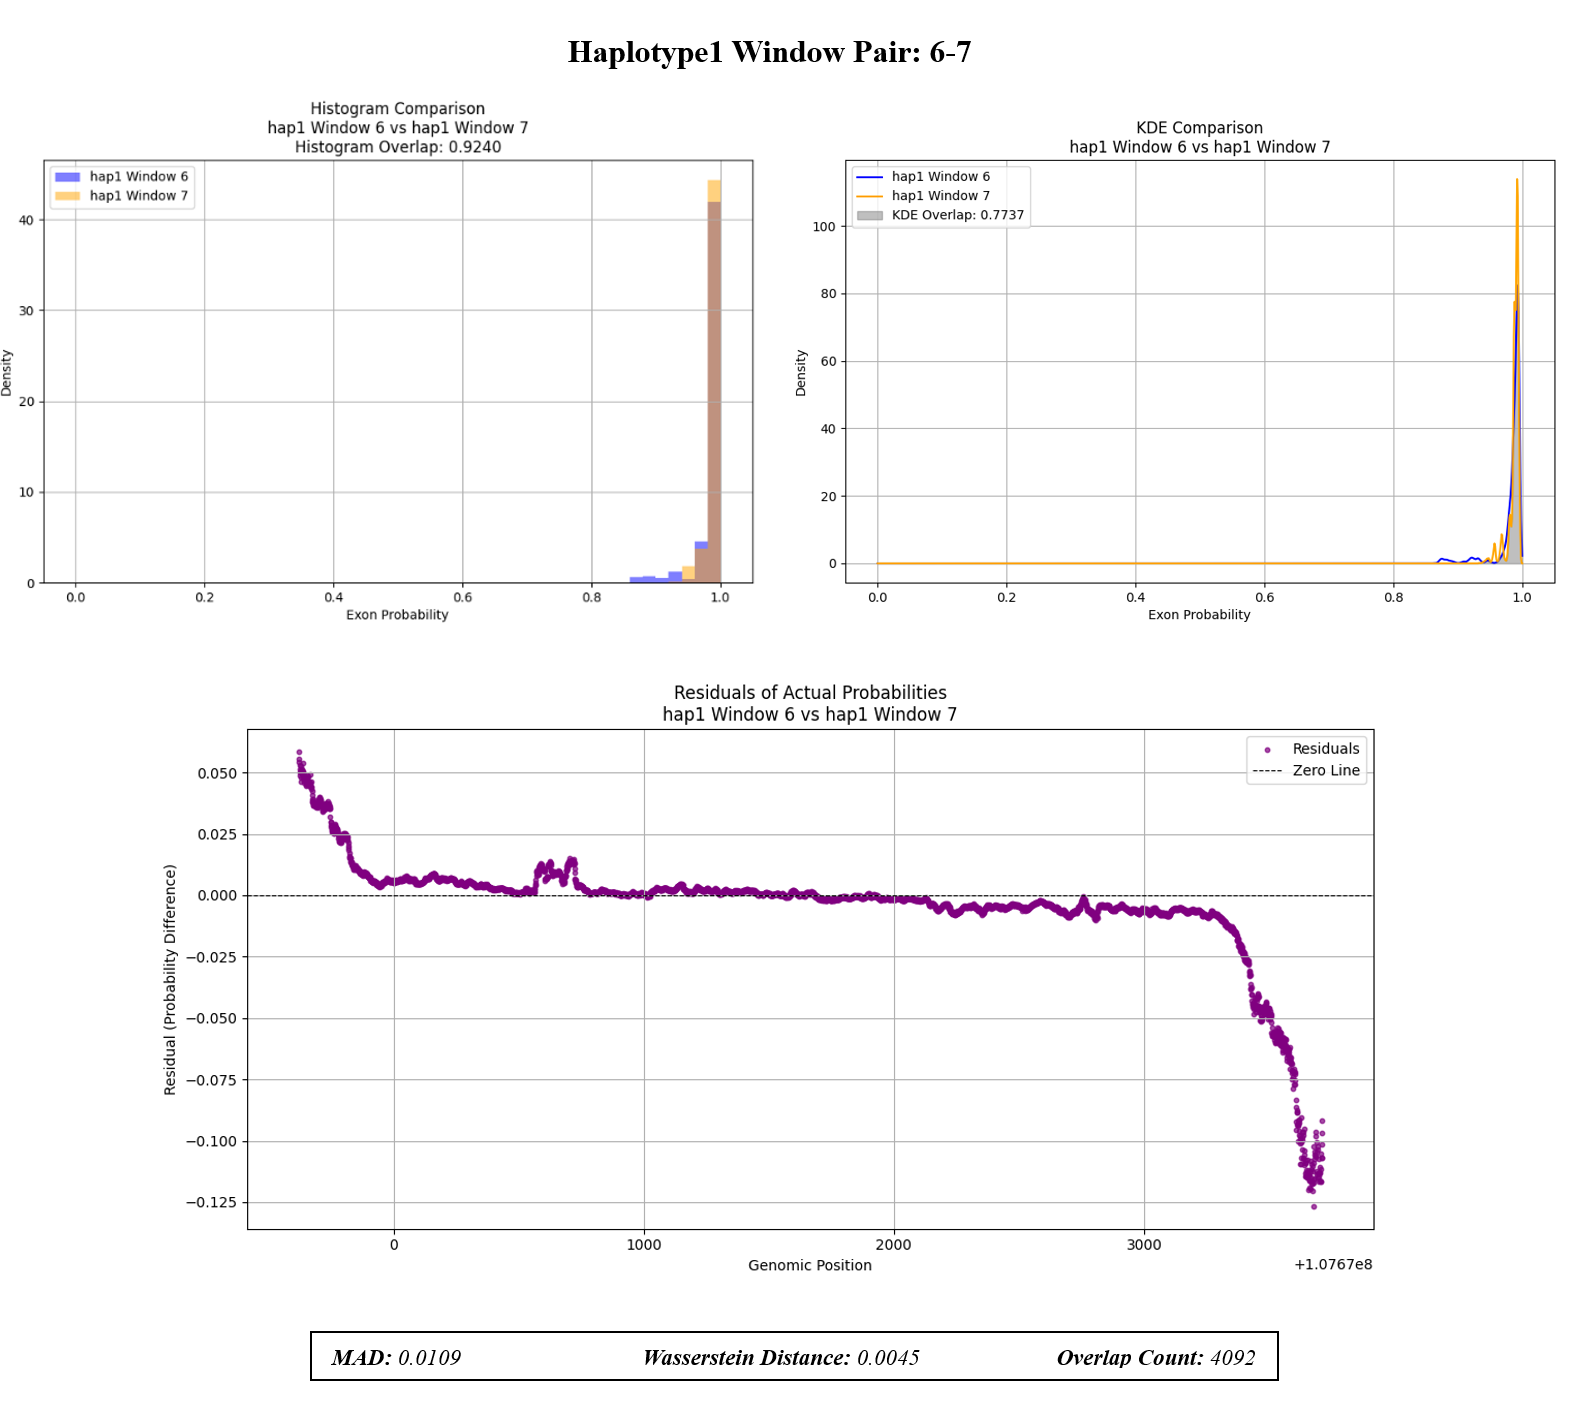
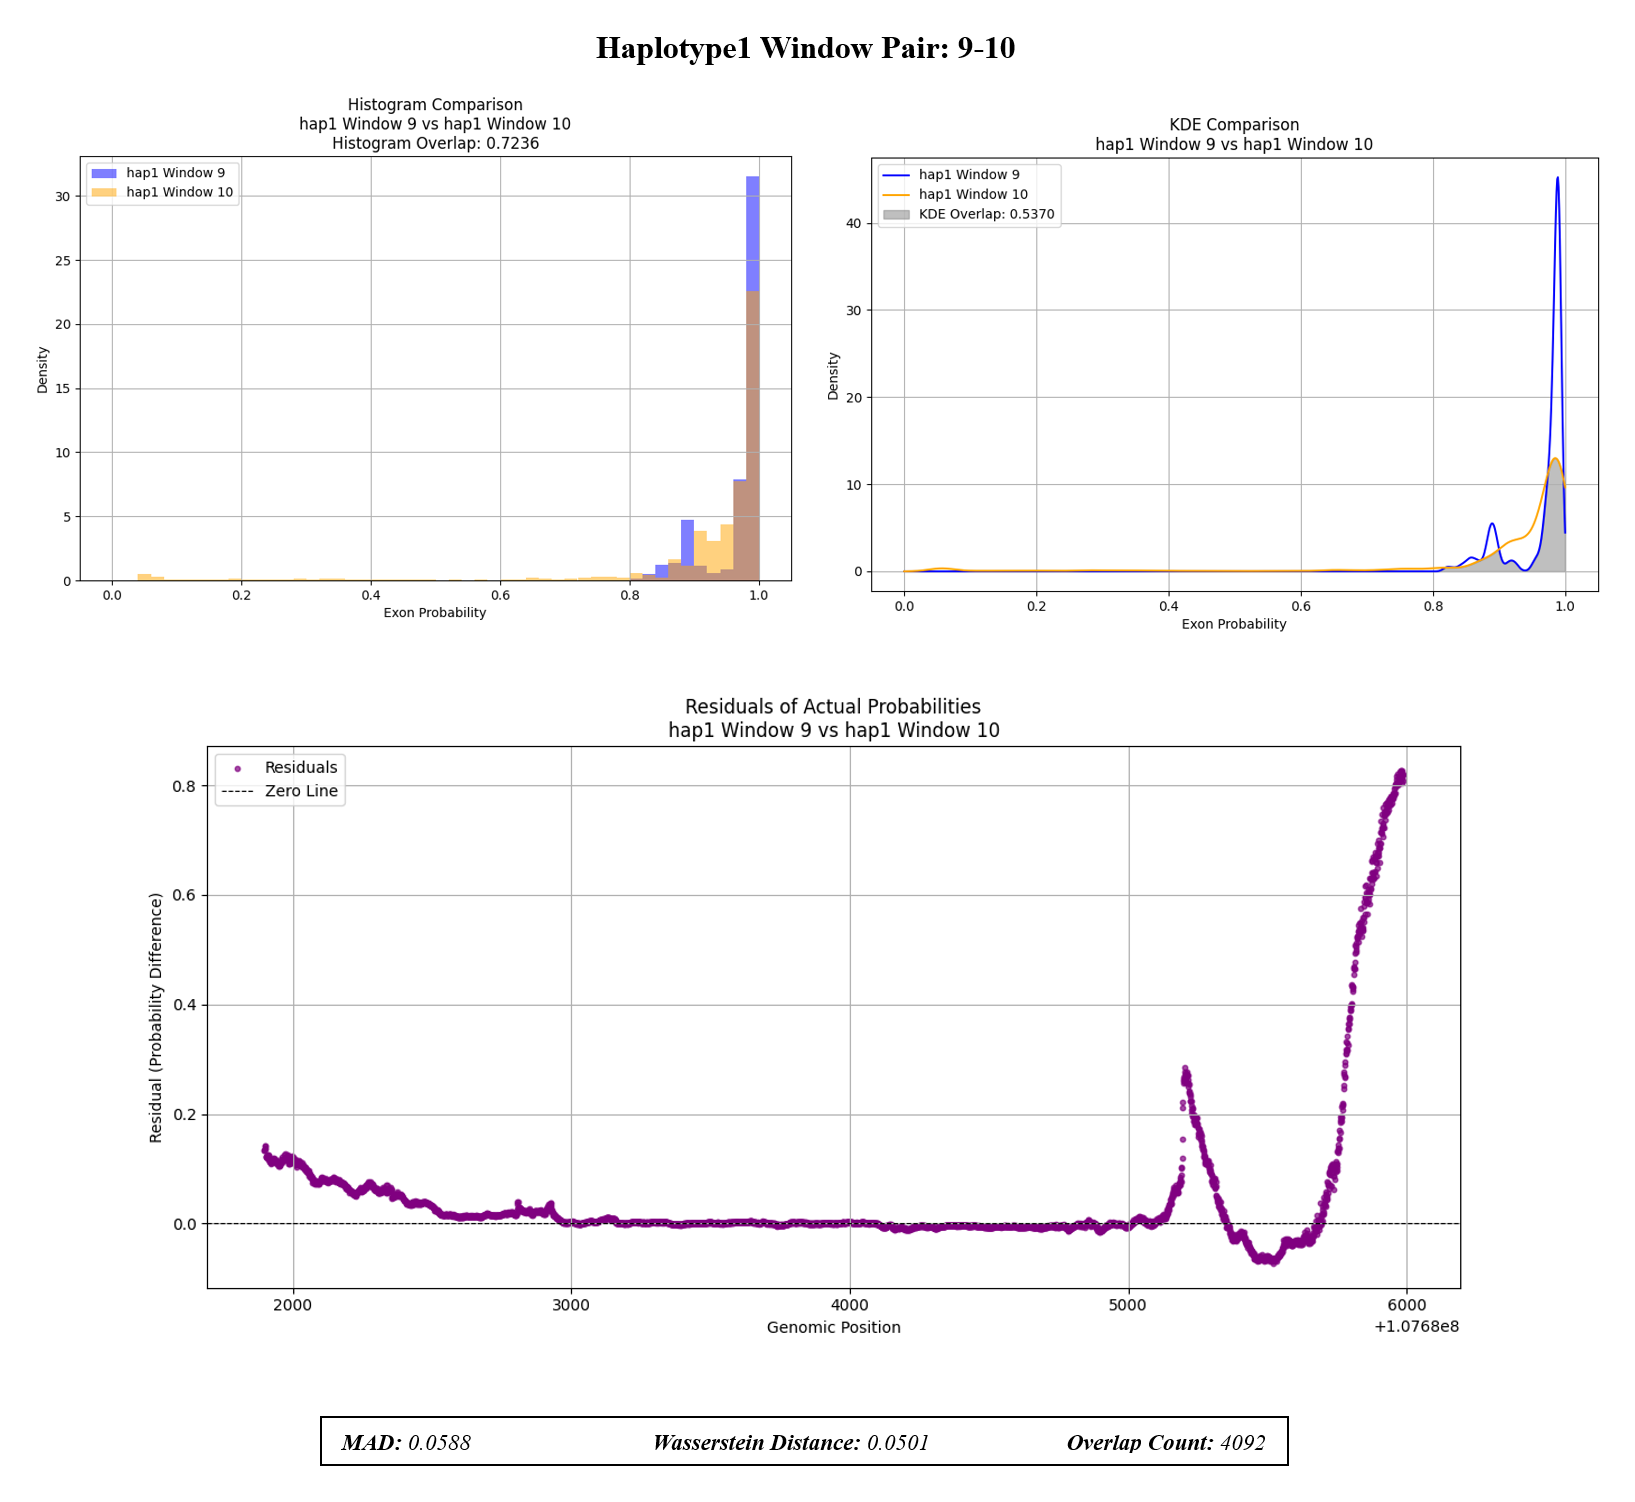

#### Sample 941_S_4420 haplotype 2

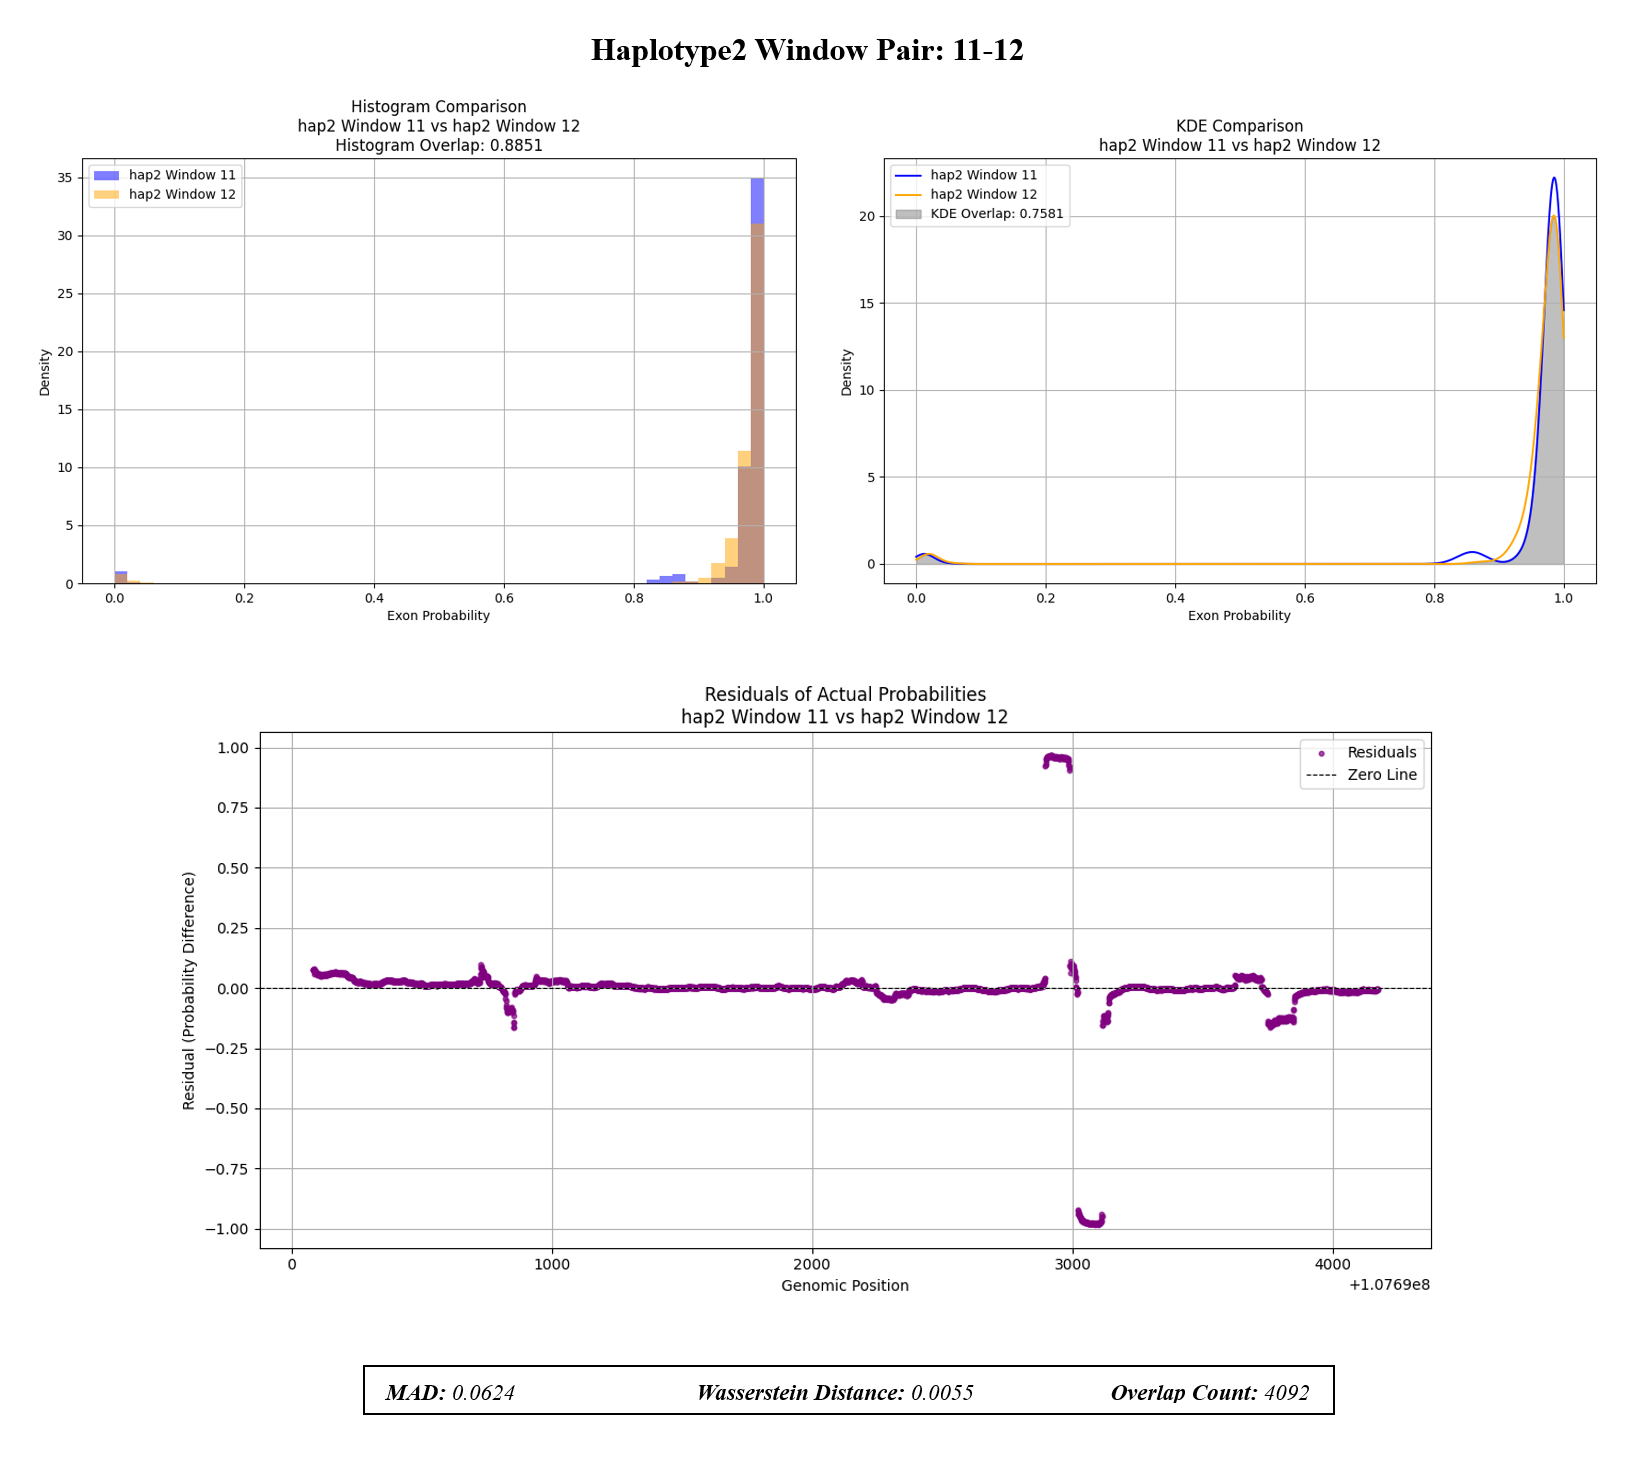
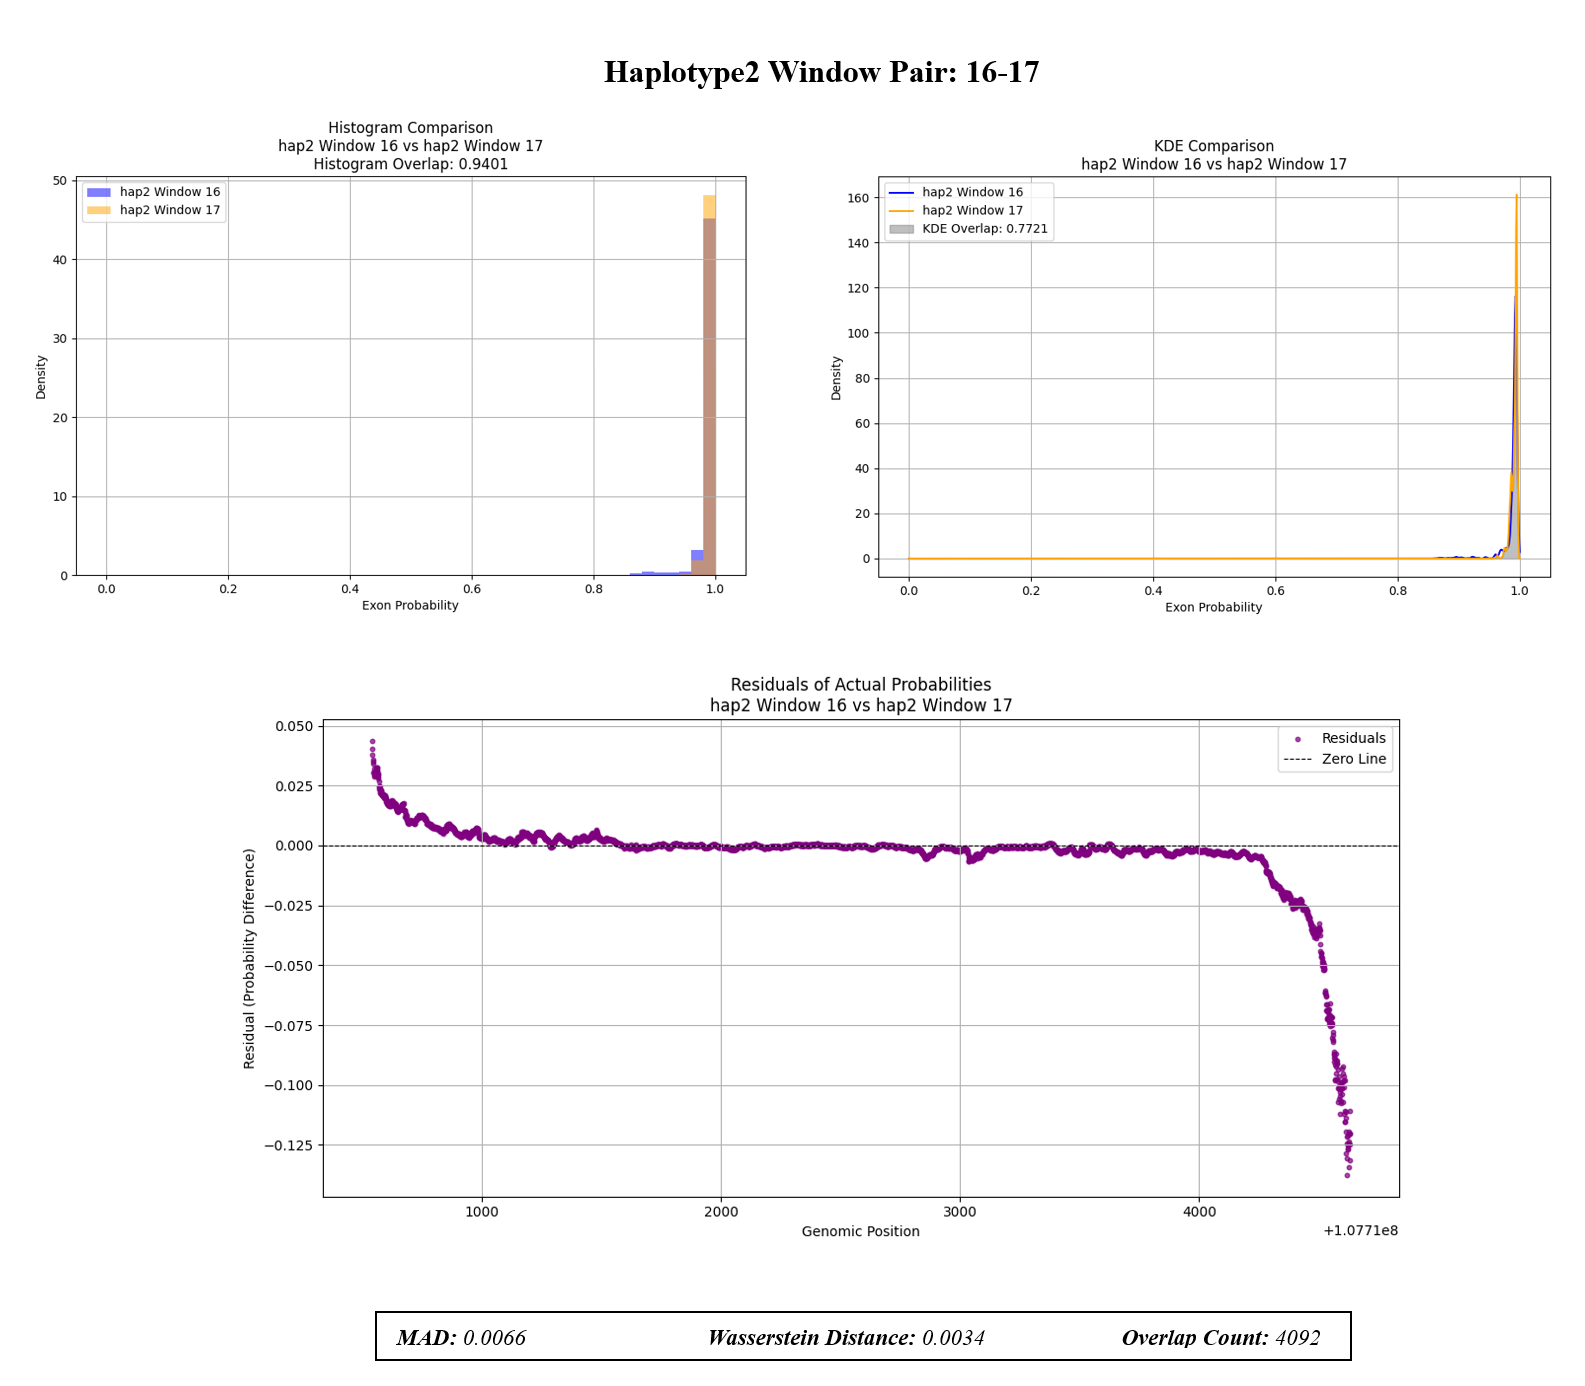
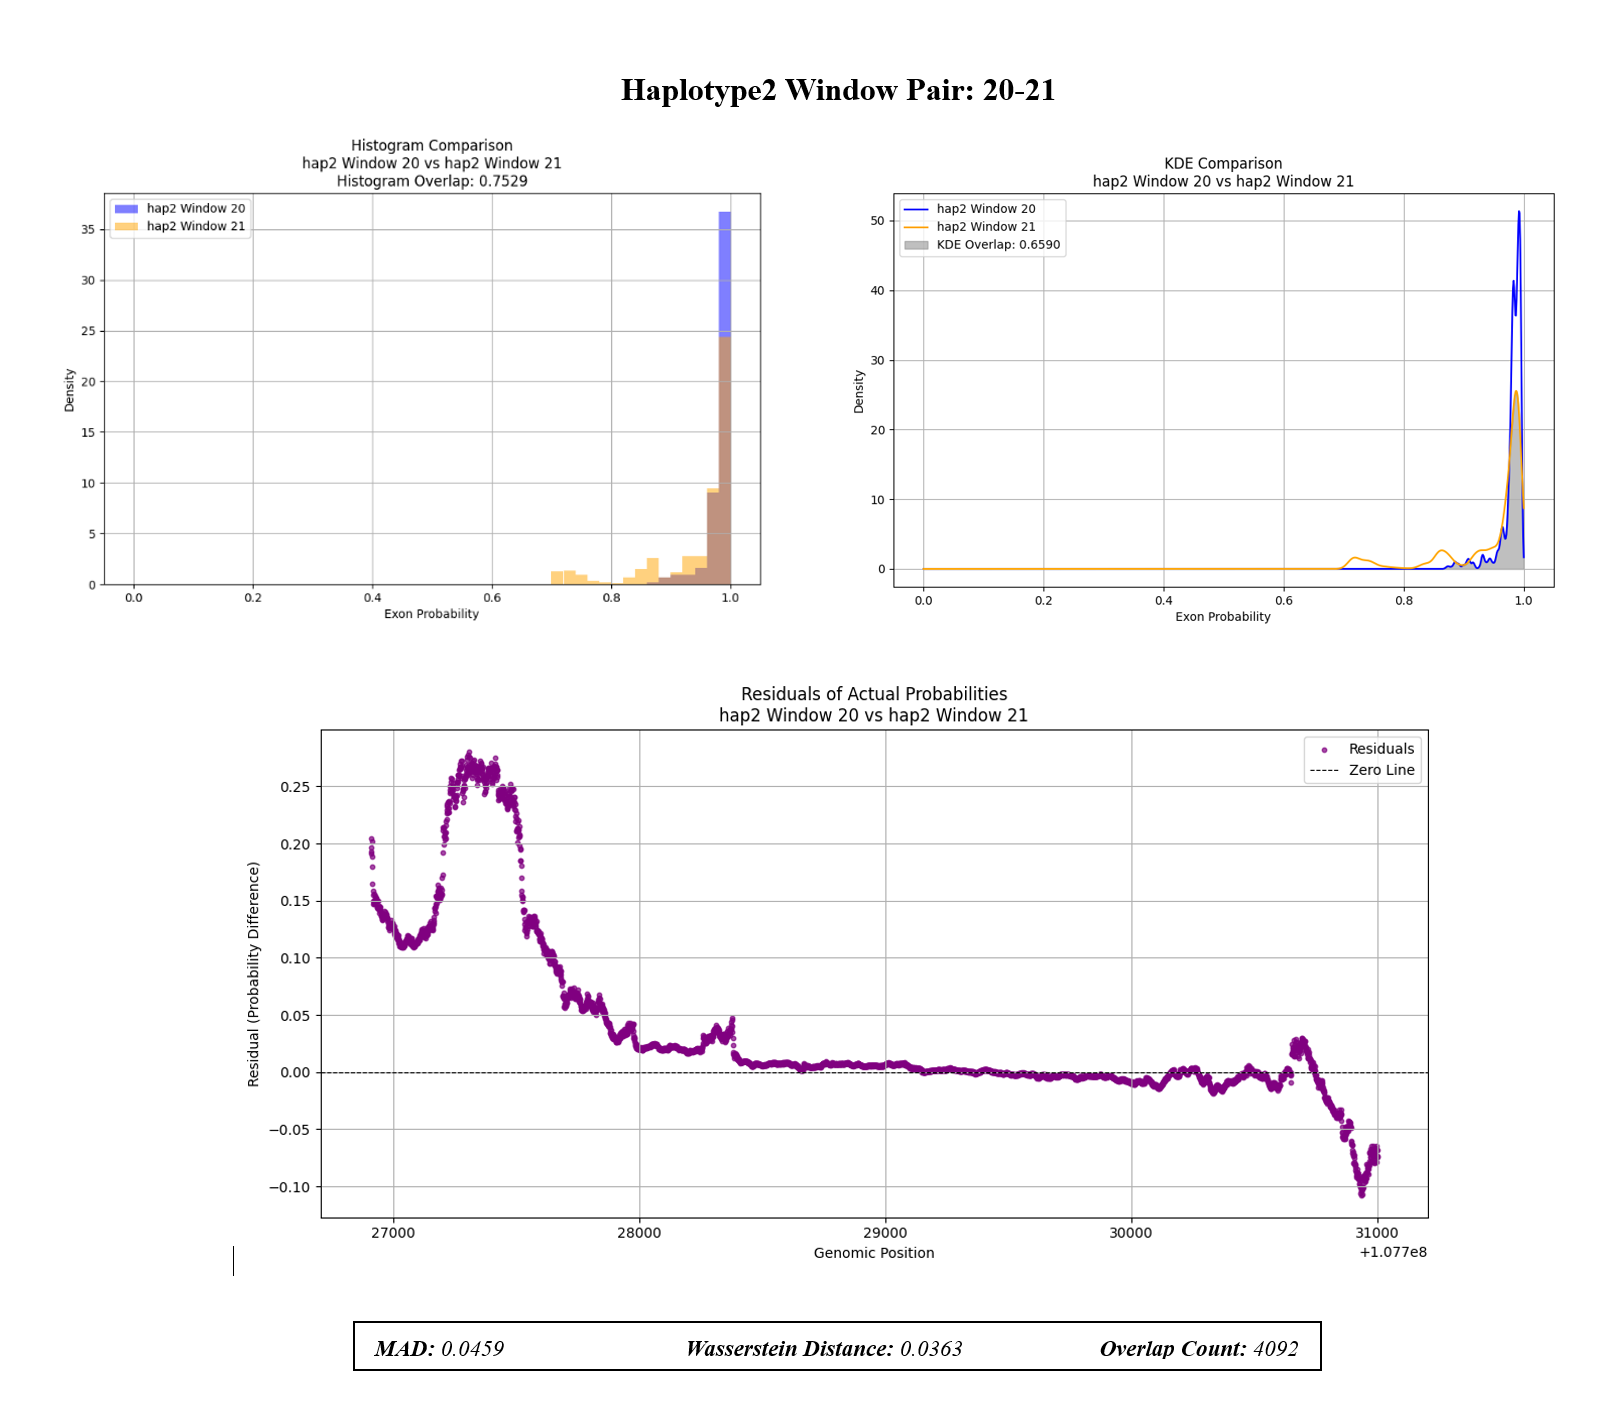

#### 941_S_4377 Summary
 

**Metrics Summary:**

    1. Mean Histogram Overlap: 0.8587
    2. Std Histogram Overlap: 0.0658
       
    1. Mean KDE Overlap: 0.7325
    2. Std KDE Overlap: 0.0792
       
    1. Mean MAD: 0.0222
    2. Std MAD: 0.0236
       
    1. Mean Wasserstein Distance: 0.0156
    2. Std Wasserstein Distance: 0.0182

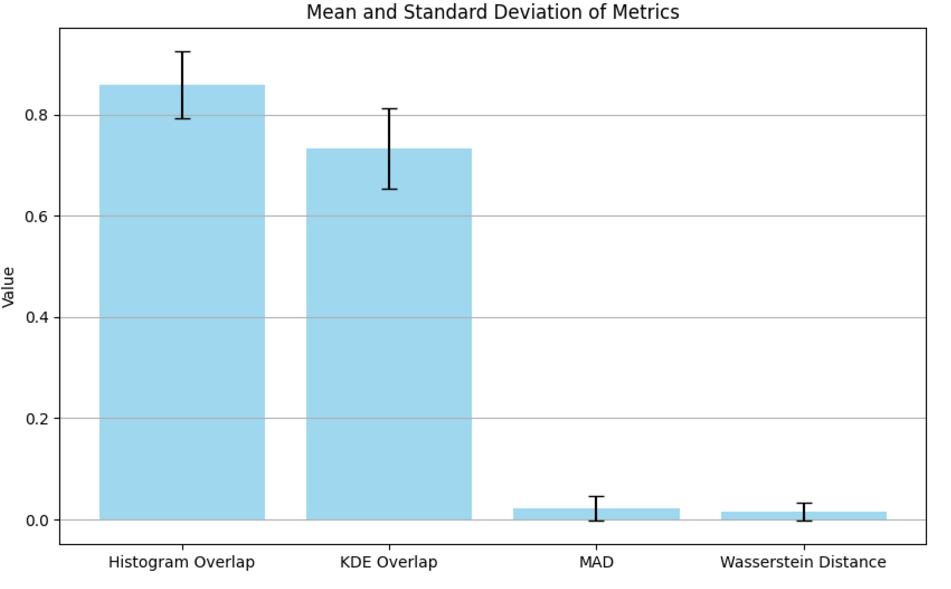
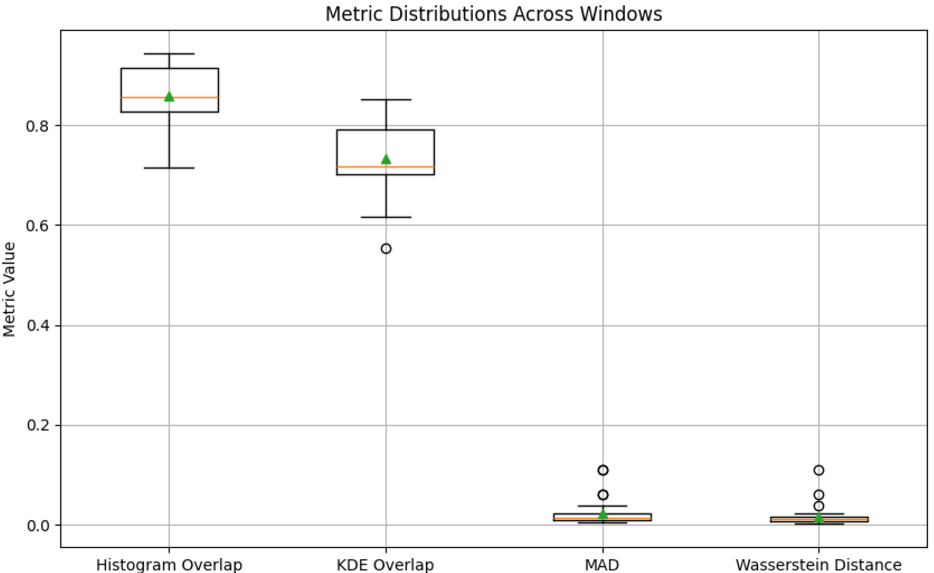

#### 941_S_4376 Summary

**Metrics Summary:**

    1. Mean Histogram Overlap: 0.8736
    2. Std Histogram Overlap: 0.0857
    
    1. Mean KDE Overlap: 0.7652
    2. Std KDE Overlap: 0.0638
    
    1. Mean MAD: 0.0222
    2. Std MAD: 0.0251
    
    1. Mean Wasserstein Distance: 0.0162
    2. Std Wasserstein Distance: 0.0221
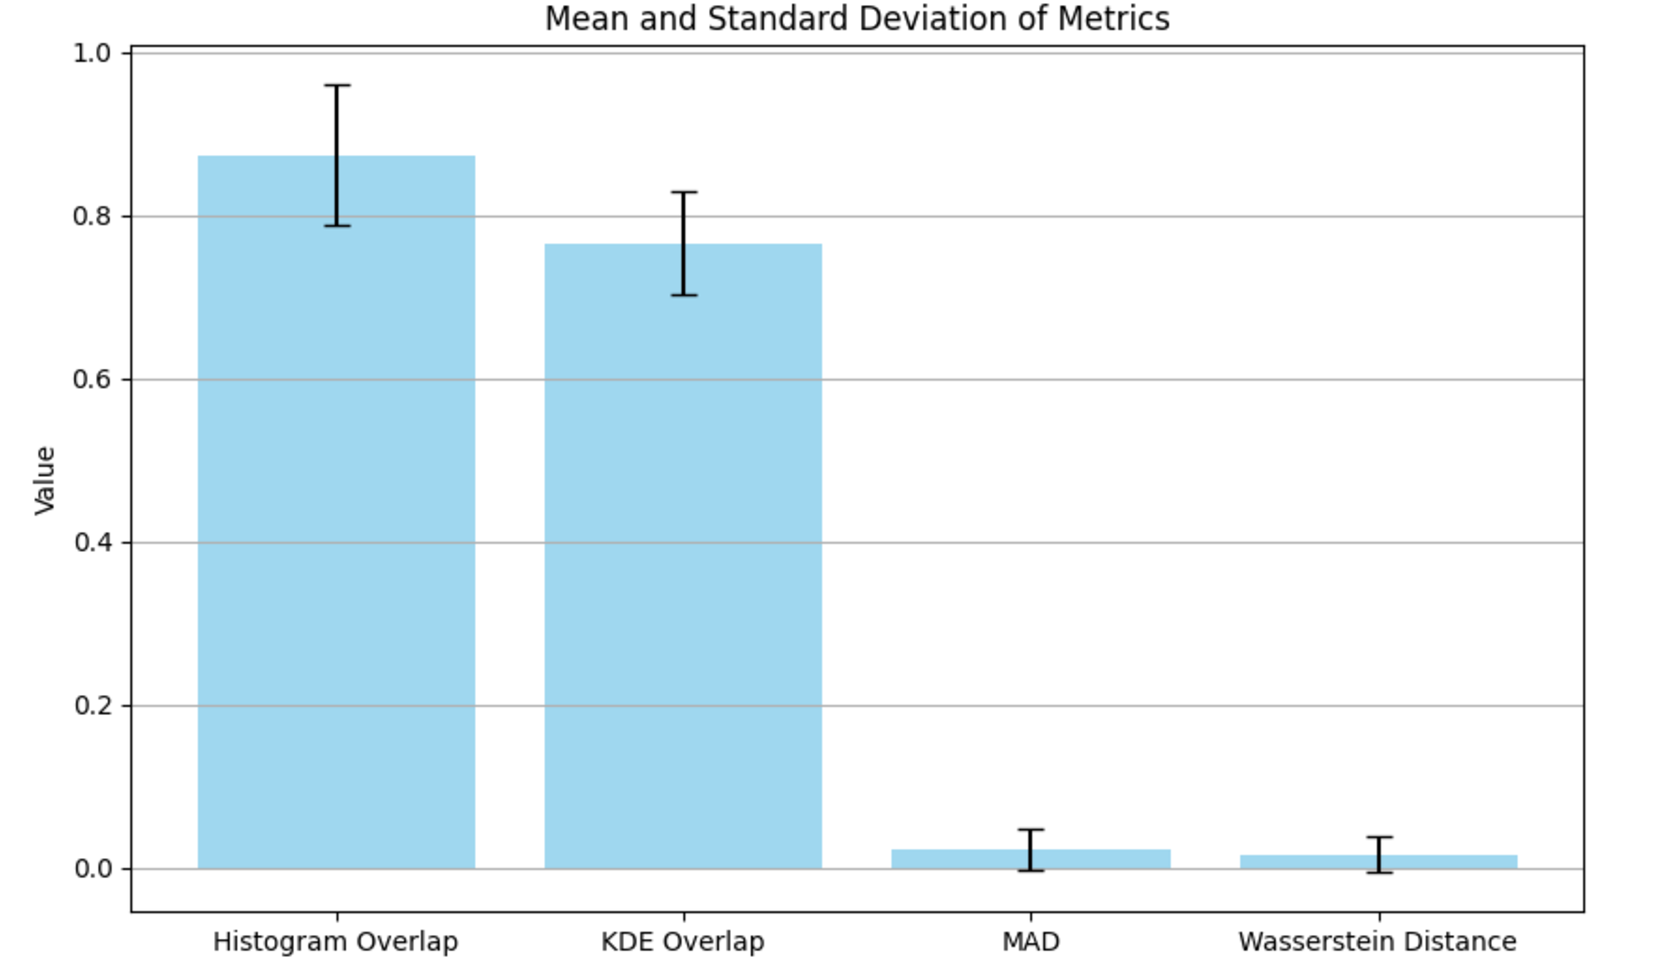
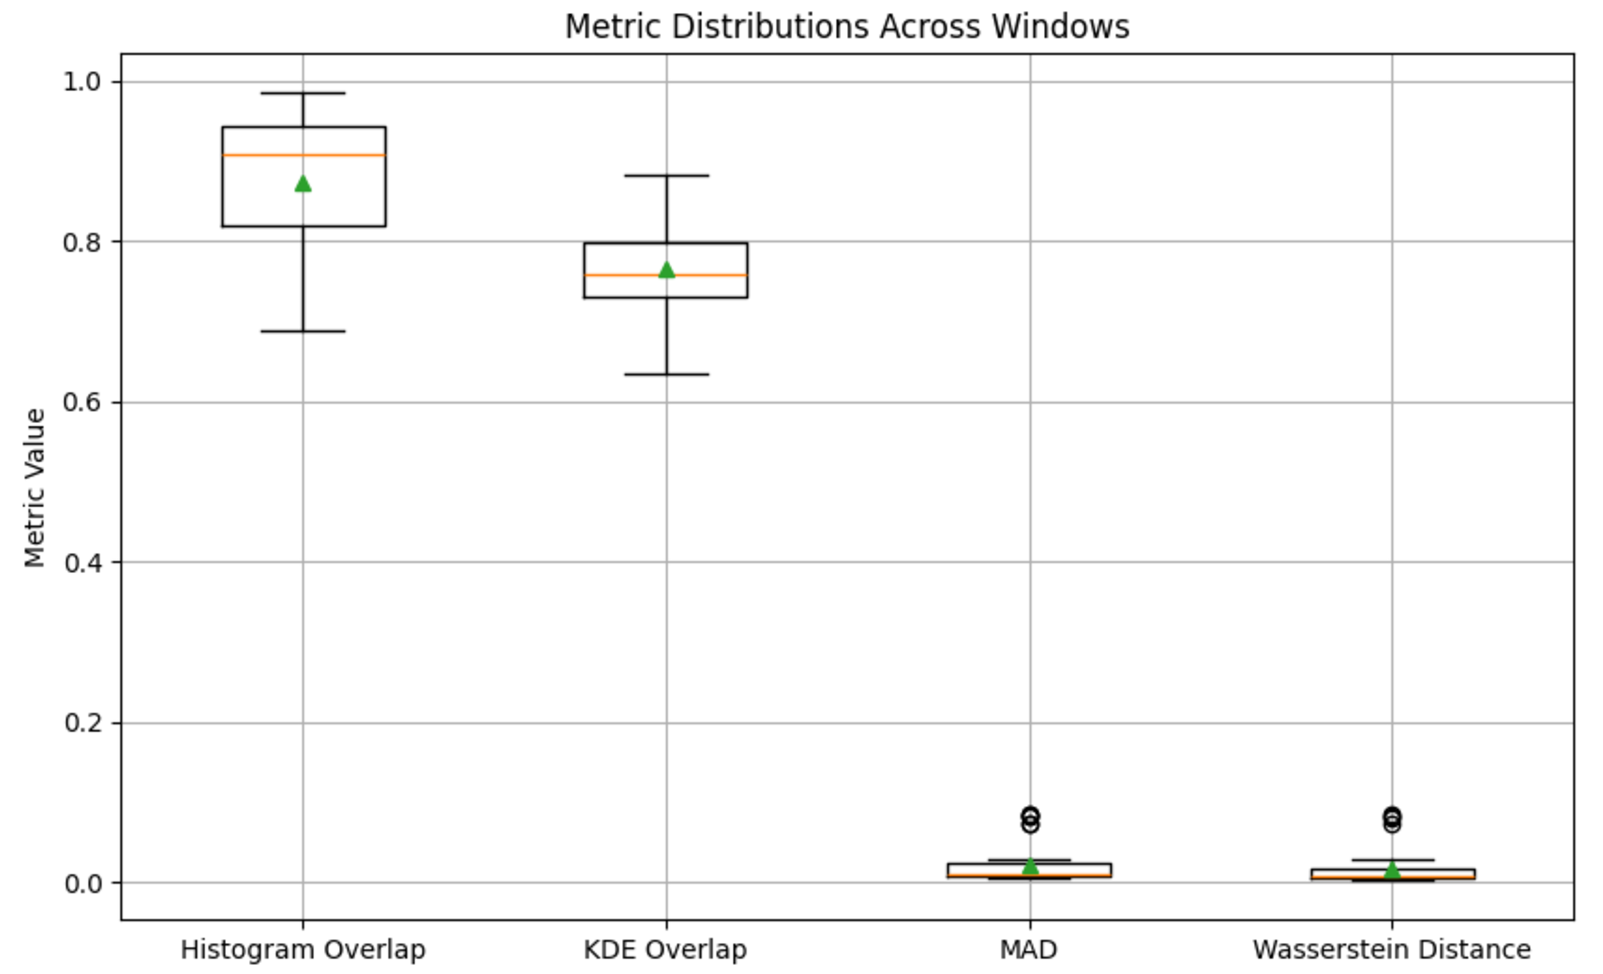


#### 941_S_4420 Summary

**Metrics Summary:**

    1. Mean Histogram Overlap: 0.8695
    2. Std Histogram Overlap: 0.0727
    
    1. Mean KDE Overlap: 0.7436
    2. Std KDE Overlap: 0.0911
    
    1. Mean MAD: 0.0223
    2. Std MAD: 0.0224
    
    1. Mean Wasserstein Distance: 0.0164
    2. Std Wasserstein Distance: 0.0194

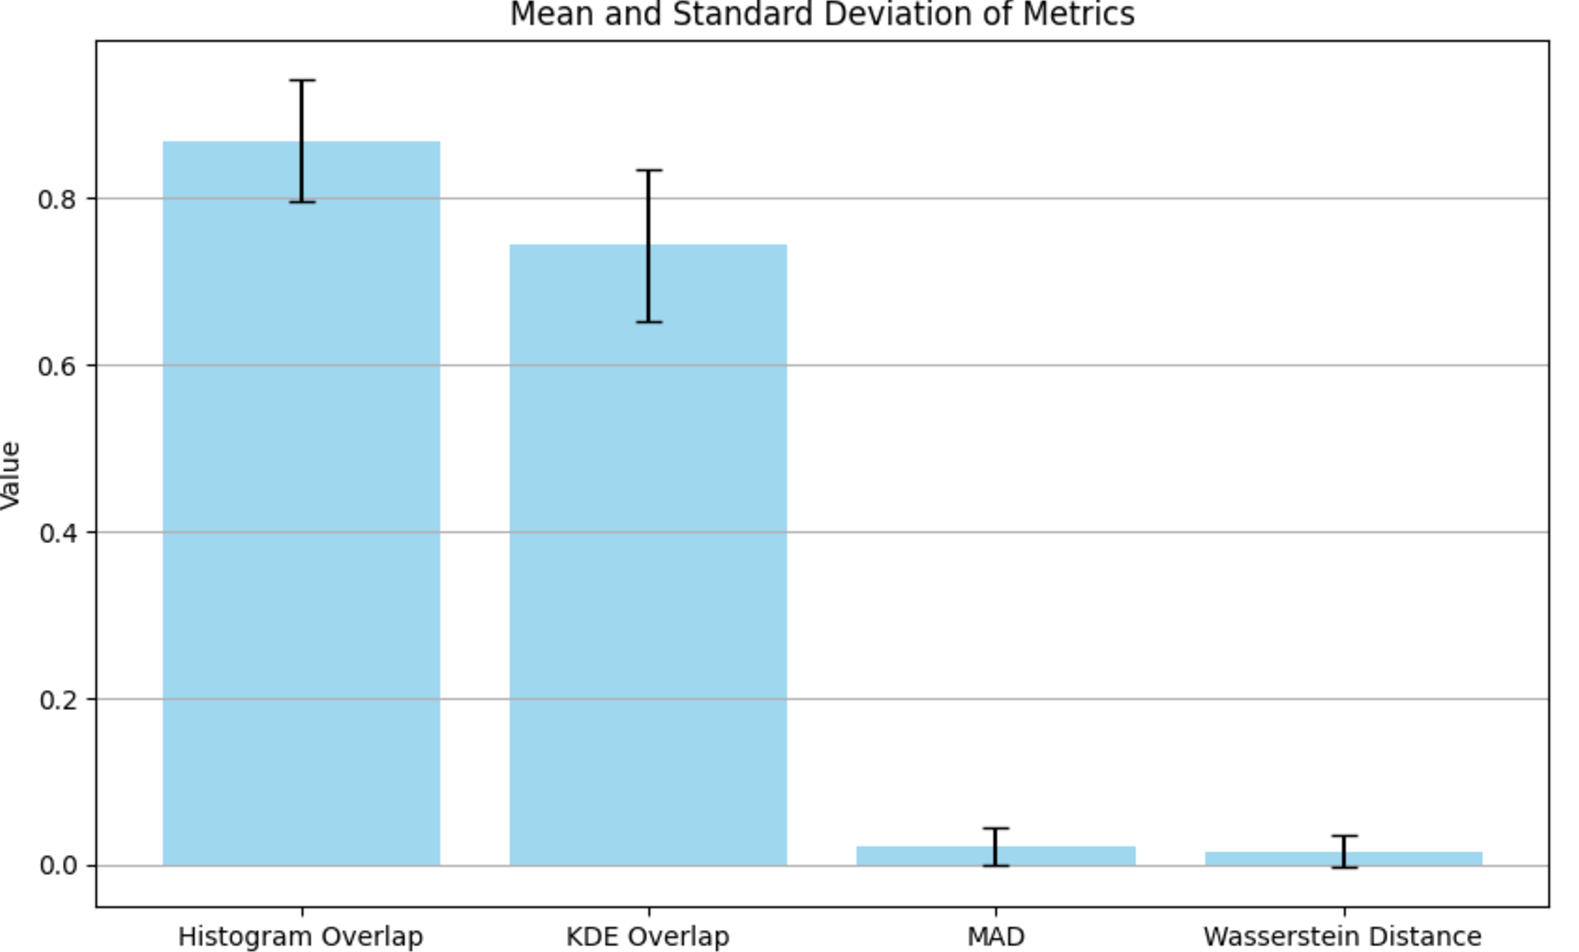
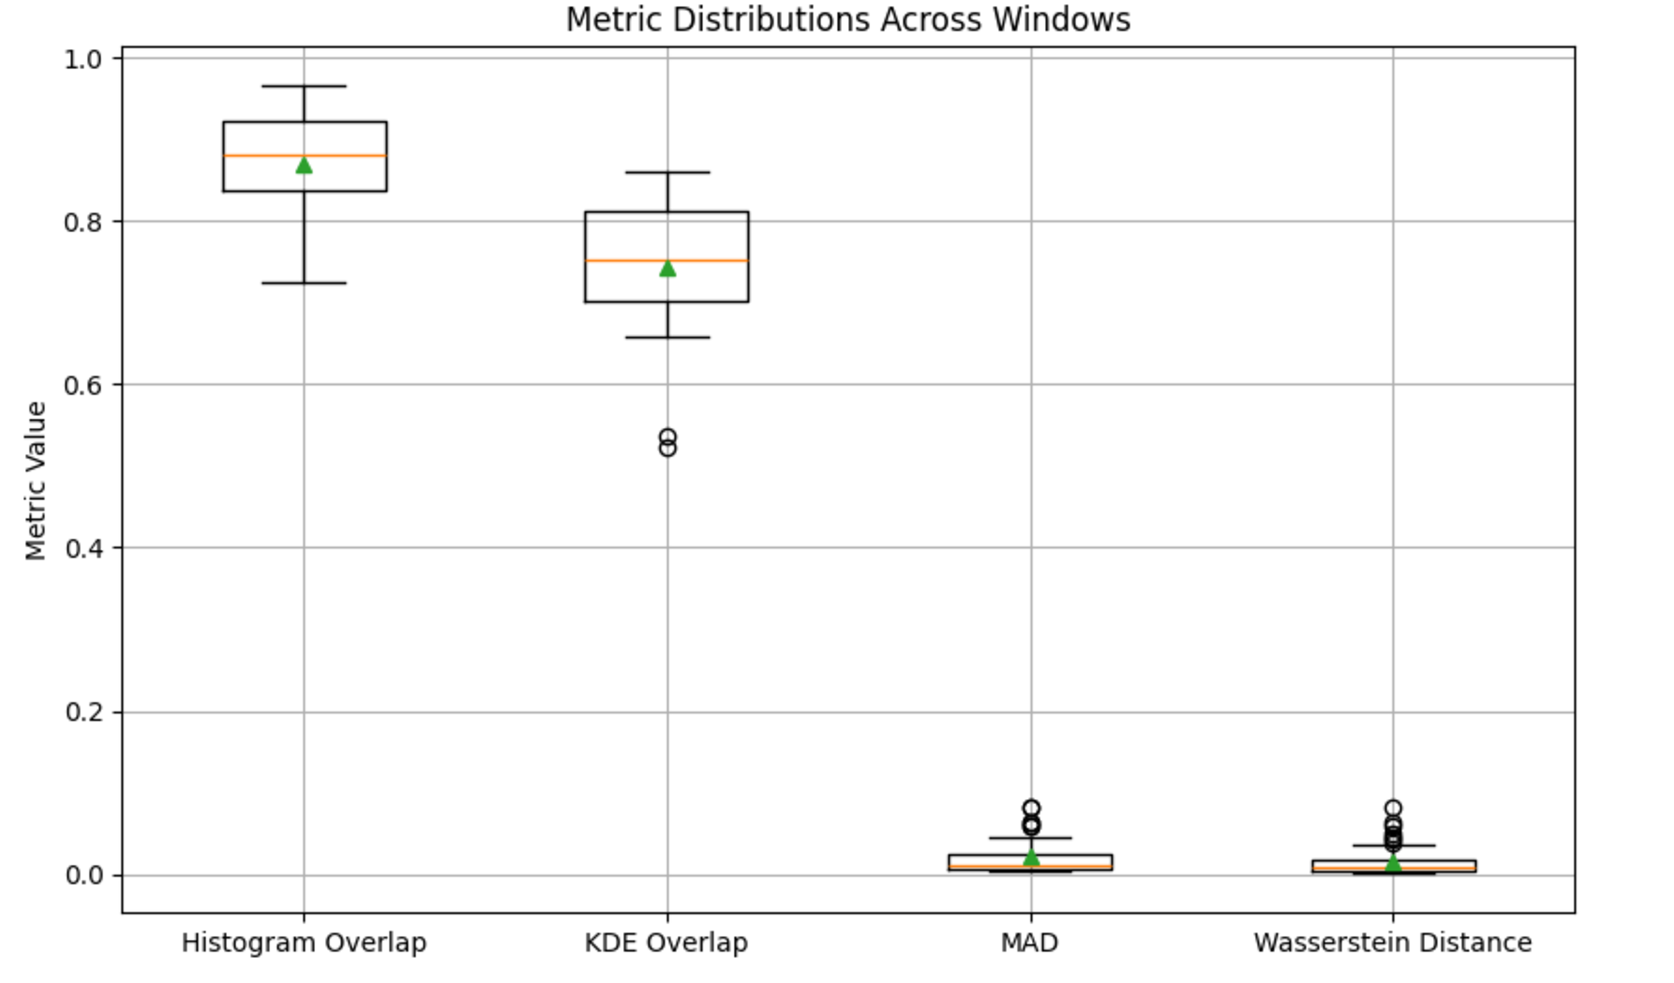